In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

In [95]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [96]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [97]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [98]:
data_inizio = '2020-02-29'
data_fine = '2020-09-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [99]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Eventuale cambio dati

In [100]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [101]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


### Strategia 1: media pesata forzata

#### Strategia con variabili statiche

In [102]:
# dati = generated_dfs[0]

500.0 512.60189357995 1.0252037871599
506.300946789975 519.8965160130539 1.0268527430360872


513.0987314015144 512.6435414396957 0.9991128608707034
512.8711364206051 516.9693919007489 1.0079908093653818
514.920264160677 515.795517555751 1.0016997843277748
515.357890858214 517.0193441640582 1.003223882539331
516.188617511136 528.2729209814769 1.0234106352995669
522.2307692463064 525.8291441656198 1.006890392392058
524.0299567059631 526.6998495305899 1.0050949240410028
525.3649031182765 526.7698735729371 1.0026742754346958
526.0673883456068 535.4651278265071 1.0178641362097252
530.766258086057 532.7101572829537 1.0036624392890128
531.7382076845054 538.403185221508 1.0125343212894664
535.0706964530067 585.9123357678214 1.0950185454965948
560.4915161104141 565.9132630256272 1.0096732006807845
563.2023895680206 577.498341674741 1.0253833299920576
570.3503656213809 580.200867315403 1.017270965861993
575.275616468392 598.9098849162762 1.0410833829408148
587.092750692334 593.6247047087099 1.0111259319905979
590.358727700522 601.5797682027826 1.0190071561167007
595.9692479516523 600.93

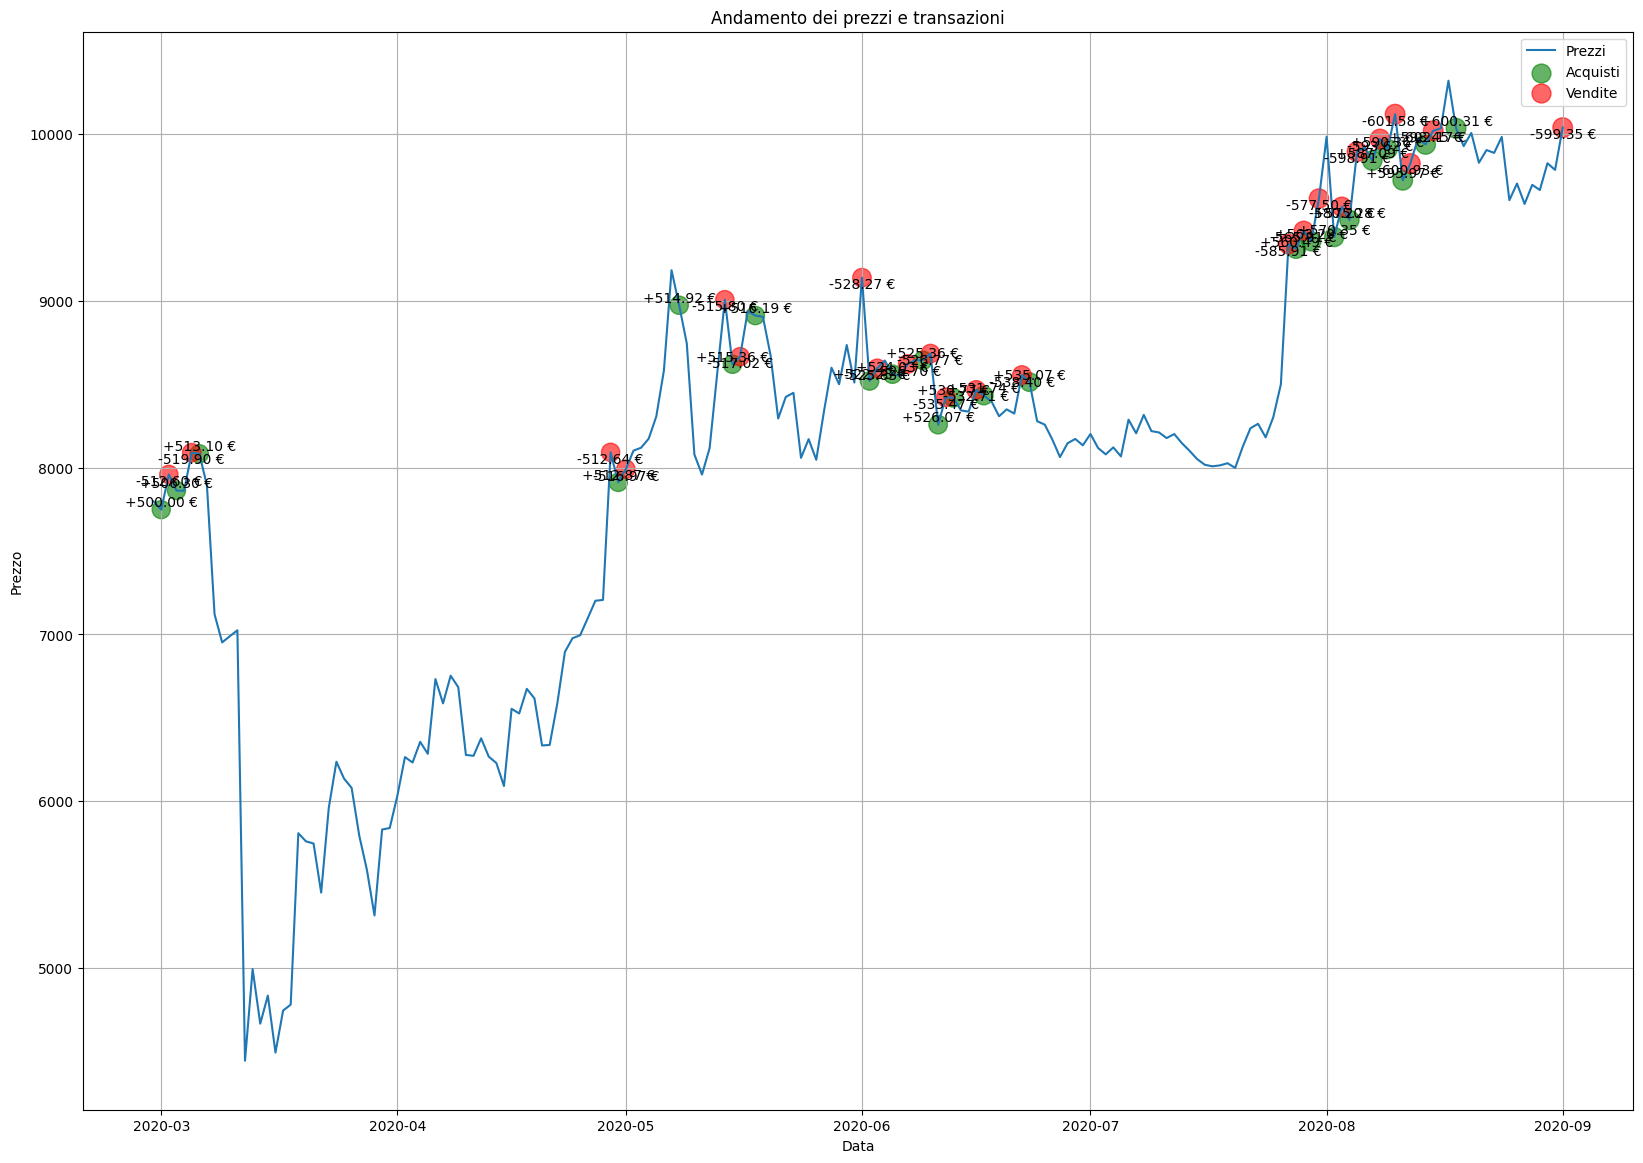

In [103]:
# Inizializzazione dei parametri fissi
liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5


# Inizializzazione dei parametri variabili 
perc_primo_acquisto = 0.5
vendita_immediata = True
perc_sbilanciamento_acquisto = 7/10
soglia_minima_acquisto = 0 # Percentuale minima di cui il prezzo dev'essere sotto al prezzo dell'ultimo acquisto per poter acquistare (viene applicato a tutti gli acquisti esclusi i primi acquisti)
soglia_minima_vendita = 0 # Percentuale minima di cui il prezzo dev'essere sopra alla media pesata di acquisto per poter vendere
perc_stop_loss = 0 # Utile solo in caso di vendita_immediata = False: per vendere, l'algoritmo aspetta che il prezzo scenda almeno di una percentuale perc_stop_loss rispetto al massimo mai raggiunto durante una salita (se vende in questo modo, viene ricalcolato da capo da lì in poi; si aggiorna solo durante le salite, non durante le discese); se perc_stop_loss = 0, semplicemente vende non appena il prezzo scende rispetto al massimo
compra_pure = False # Se è True, nel caso ci fosse bisogno di un acquisto che è superiore alla somma tra liquidità mobile e liquidità fissa, compra con tutto quello che ha (quindi prima fa una ricarica della liquidità mobile con la liquidità fissa che ha, e se anche questa non basta compra con tutta la liquidità mobile rimasta; anche se così facendo non rispetterà la percentuale di sbilanciamento richiesta); se è False, in questi casi non fa niente

liquidita_mobile = liquidita_mobile_iniziale
liquidita_fissa = liquidita_fissa_iniziale
bitcoin = bitcoin_iniziali

ultima_azione_effettiva = None
ultimi_acquisti = []
transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
giorni_acquisto = []
giorni_vendita = []

prezzo_massimo = 0
in_salita = False

valori_portafoglio = [] # Solo per debug
rapporti_valori_portafoglio = []

def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
    global transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva
    ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
    nuova_transazione = pd.DataFrame({
        'Data': [dati['Timestamp'].iloc[i]],
        'Numero giorno': i,
        'Prezzo': [dati['Price'].iloc[i]],
        'Ultima Azione': [ultima_azione],
        'Azione Attuale': [azione],
        '% acquisto/vendita di LM': [perc],
        'Quantità in € Comprata/Venduta': [quantita_euro],
        'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
        'Liquidità Mobile': [liquidita_mobile],
        'Liquidità Fissa': [liquidita_fissa],
        'Bitcoin Posseduti': [bitcoin],
        'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
    })
    transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
    if azione != "-":
        ultima_azione_effettiva = azione

def primo_acquisto(i):
    global liquidita_mobile, bitcoin, ultimi_acquisti
    quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
    bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
    liquidita_mobile -= quantita_primo_acquisto
    bitcoin += bitcoin_acquistati
    ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
    giorni_acquisto.append(i)
    aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

def calcola_prezzo_medio_pesato():
    return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

# Primo acquisto al giorno 1
primo_acquisto(1)

for i in range(2, len(dati)):
    prezzo_oggi = dati['Price'].iloc[i]
    prezzo_ieri = dati['Price'].iloc[i-1]
    prezzo_laltro_ieri = dati['Price'].iloc[i-2]
    azione = "-"  # Inizializziamo l'azione come nulla
    
    if bitcoin > 0:
        prezzo_medio_pesato = calcola_prezzo_medio_pesato()
        
        # Aggiorna il prezzo massimo se siamo in una salita
        if prezzo_oggi > prezzo_ieri:
            in_salita = True
            if prezzo_ieri < prezzo_laltro_ieri:
                prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
            prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
        else:
            in_salita = False
        
        if vendita_immediata:
            if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita immediata
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                    ultimi_acquisti = []
        else:
            if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita con stop-loss
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita (Stop-Loss)'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                    valori_portafoglio.append(bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa) # Solo per debug
                    if len(valori_portafoglio) > 1:
                        print('Rapporti portafoglio:', valori_portafoglio[-1] / valori_portafoglio[-2])
                        rapporti_valori_portafoglio.append(valori_portafoglio[-1] / valori_portafoglio[-2])
                    ultimi_acquisti = []
    
    if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
        if not ultimi_acquisti:
            if prezzo_oggi < prezzo_ieri:
                # Primo acquisto dopo una vendita
                primo_acquisto(i)
                azione = 'Primo Acquisto'
                # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
        elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
            # Calcolo del prezzo desiderato di acquisto
            ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
            A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

            # Calcolo della quantità da acquistare
            S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
            P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
            quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)
            # print(i, A, S, P, quantita_da_acquistare_euro)

            if quantita_da_acquistare_euro >= min_acquisto:
                if quantita_da_acquistare_euro > liquidita_mobile:
                    # Usa la liquidità fissa se necessario
                    liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                    liquidita_mobile += liquidita_aggiuntiva
                    liquidita_fissa -= liquidita_aggiuntiva

                if quantita_da_acquistare_euro <= liquidita_mobile:
                    # Acquisto
                    bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                    vecchia_liquidita_mobile = liquidita_mobile
                    liquidita_mobile -= quantita_da_acquistare_euro
                    bitcoin += bitcoin_acquistati
                    ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                    giorni_acquisto.append(i)
                    azione = 'Acquisto'
                    aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
    
    if azione == "-":
        # Se non è stata effettuata nessuna azione, aggiungiamo comunque una riga alla tabella
        aggiorna_transazioni(i, azione, 0, 0, 0)

    # print(i, prezzo_massimo)

# Grafico
# plt.figure(figsize=(20, 7))
# plt.grid(True)
# plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
# plt.scatter(dati['Timestamp'].iloc[giorni_acquisto], dati['Price'].iloc[giorni_acquisto], color='green', label='Acquisti')
# plt.scatter(dati['Timestamp'].iloc[giorni_vendita], dati['Price'].iloc[giorni_vendita], color='red', label='Vendite')
# plt.legend()
# plt.show()

etichette = True

# Preparazione dei dati per il grafico
acquisti = transazioni[transazioni['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
vendite = transazioni[transazioni['Azione Attuale'].isin(['Vendita', 'Vendita (Stop-Loss)'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
max_vendita = vendite['Quantità in € Comprata/Venduta'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['Data'], acquisti['Prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"+{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['Data'], vendite['Prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"-{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [104]:
# Possibili generalizzazioni della strategia:
# - Aggiungere un vincolo che fa comprare non solo se il prezzo è sceso ancora, ma se è sceso almeno di una certa percentuale (il caso attuale corrisponderebbe a una percentuale sempre pari a 0)
# - Permettere una vendita iniziale e varie vendite successive in modo analogo a quello che faccio con gli acquisti (il caso attuale corrisponderebbe a una vendita iniziale del 100%)

In [105]:
transazioni['Liquidità Fissa']

0      0
1      0
2      0
3      0
4      0
      ..
180    0
181    0
182    0
183    0
184    0
Name: Liquidità Fissa, Length: 185, dtype: object

In [106]:
# valori_portafoglio.insert(0, liquidita_fissa_iniziale+liquidita_mobile_iniziale)
# valori_portafoglio

In [107]:
# rapporti_valori_portafoglio.insert(0, valori_portafoglio[1]/(valori_portafoglio[0]))
# rapporti_valori_portafoglio

In [108]:
# np.mean(rapporti_valori_portafoglio)

In [109]:
# np.std(rapporti_valori_portafoglio)

1.0253463839197774
1.0343166813078046
1.0894142696034983
1.0463189653856633
1.0846146879330583
1.0128844029500643
1.079068173002969
1.0276750616202455
1.0008525414189127
1.0476297891876365
1.044967580912867
1.0955092006692346
1.0378282020993852
1.0552910666409256
1.063193717503451
1.0477356767118904
1.0354556496305645
1.0333300412061646
1.0310803155449972
1.0021625164645644
1.0577818885254886
1.0699044191683305
1.0517623404711662
1.0314079352926901


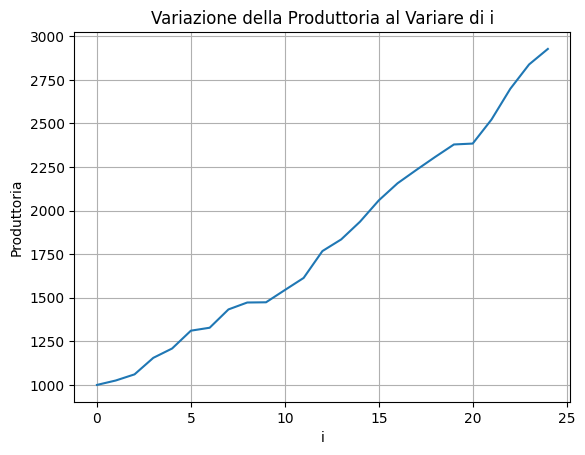

[1000,
 1025.3463839197773,
 1060.5328690068623,
 1155.3596408796134,
 1208.8747040935086,
 1311.163259930549,
 1328.0568157048142,
 1433.0638417667346,
 1472.7239718933747,
 1473.9795300780395,
 1544.184864362548,
 1613.6231221951953,
 1767.738976777453,
 1834.609364049951,
 1936.046872657703,
 2058.3928718018738,
 2156.651648476268,
 2233.117133699822,
 2307.547019784229,
 2379.266309294041,
 2384.4115118614727,
 2522.187312038744,
 2698.4993511205453,
 2838.179993294468,
 2927.3213668728686]

In [110]:
# Inizializza la produttoria e la lista per memorizzare i valori
produttoria = 1000
valori = [produttoria]

# Calcola la produttoria per 100 volte
for i in range(1, 25):
    cas = random.uniform(1, 1.1)
    print(cas)
    produttoria *= cas
    valori.append(produttoria)

# Crea il grafico
plt.plot(valori)
plt.title('Variazione della Produttoria al Variare di i')
plt.xlabel('i')
plt.ylabel('Produttoria')
plt.grid()
plt.show()

valori

In [111]:
transazioni[:60]

,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
0,2020-03-01,1,7748.164551,-,Primo Acquisto,0.5,500.000000,0.064467,500.000000,0,0.064467,999.500000
1,2020-03-02,2,7959.358398,Primo Acquisto,Vendita,1.0,512.601894,0.064467,1012.601894,0,0.000000,1012.601894
2,2020-03-03,3,7862.485352,Vendita,Primo Acquisto,0.5,506.300947,0.064330,506.300947,0,0.064330,1012.095593
3,2020-03-04,4,7861.055176,Primo Acquisto,-,0.0,0.000000,0.000000,506.300947,0,0.064330,1012.003589
4,2020-03-05,5,8089.786133,Primo Acquisto,Vendita,1.0,519.896516,0.064330,1026.197463,0,0.000000,1026.197463
5,2020-03-06,6,8082.739746,Vendita,Primo Acquisto,0.5,513.098731,0.063417,513.098731,0,0.063417,1025.684364
6,2020-03-07,7,7894.343750,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,1013.736796
7,2020-03-08,8,7121.034180,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,964.695582
8,2020-03-09,9,6952.206055,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,953.988956
9,2020-03-10,10,6989.210938,Primo Acquisto,-,0.0,0.000000,0.000000,513.098731,0,0.063417,956.335706


In [112]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [113]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale+liquidita_fissa_iniziale, bitcoin_iniziali, dati['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [114]:
valore_iniziale = liquidita_fissa_iniziale+liquidita_mobile_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = liquidita_mobile + bitcoin * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [115]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.199664249040099
Punteggio rendimento: 11.98%
Valore finale del portafoglio in euro: 1199.664249040099


##### Grafico andamenti

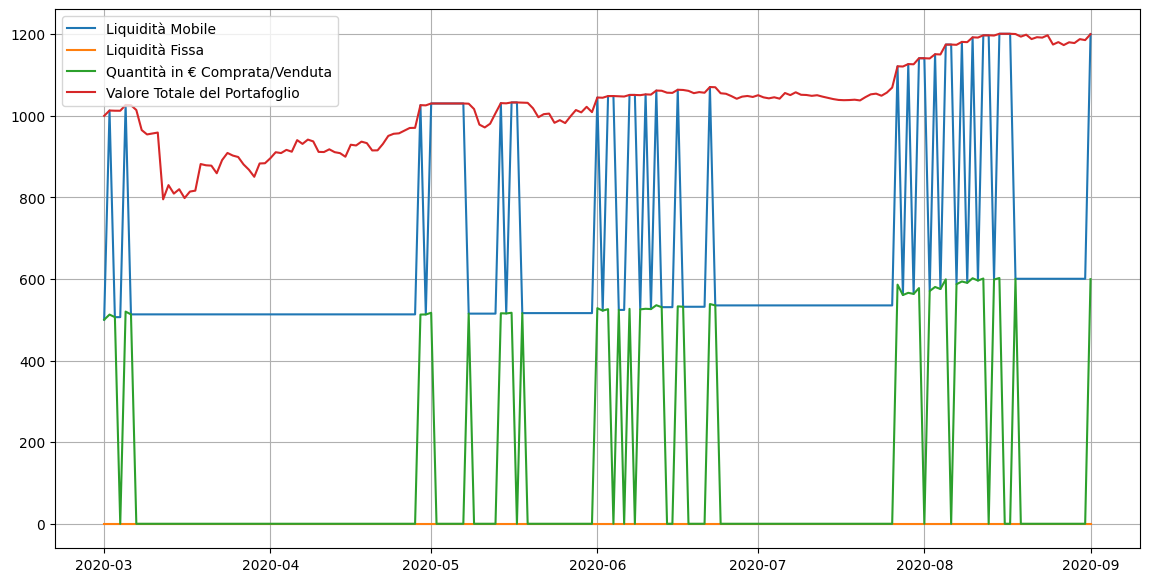

In [116]:
# Creiamo un DataFrame per memorizzare i dati del portafoglio
portafoglio = transazioni[['Data', 'Liquidità Mobile', 'Liquidità Fissa', 'Quantità in € Comprata/Venduta', 'Valore Totale del Portafoglio']]

# Creiamo un grafico multi-linea
plt.figure(figsize=(14,7))

# Grafico della liquidità mobile
plt.plot(portafoglio['Data'], portafoglio['Liquidità Mobile'], label='Liquidità Mobile')

# Grafico della liquidità fissa
plt.plot(portafoglio['Data'], portafoglio['Liquidità Fissa'], label='Liquidità Fissa')

# Grafico della quantità in euro comprata/venduta
plt.plot(portafoglio['Data'], portafoglio['Quantità in € Comprata/Venduta'], label='Quantità in € Comprata/Venduta')

# Grafico del valore totale del portafoglio
plt.plot(portafoglio['Data'], portafoglio['Valore Totale del Portafoglio'], label='Valore Totale del Portafoglio')

# Aggiungiamo una legenda
plt.legend()

plt.grid()

# Mostriamo il grafico
plt.show()

#### Strategia con variabili dinamiche

798.9194377394747 922.3864512321418 1.154542507867895 1123.4670134926673
37.44890044975551 41.41586502382212 1.1059300680774062 1127.4339780667337
Rapporti portafoglio: 1.0035310022692467
725.5642635360268 836.7750783380621 1.1532749342698483 1238.644792868769
Rapporti portafoglio: 1.0986406450094168
41.2881597622925 53.02854052397721 1.284352241157692 1250.3851736304537
Rapporti portafoglio: 1.0094784080385897
1250.3851736304537 1390.9976023857712 1.112455291154048 1390.9976023857712
Rapporti portafoglio: 1.112455291154048


903.2900832032913 1032.9811815837559 1.1435763558042702 1520.6887007662358
Rapporti portafoglio: 1.0932360330154594


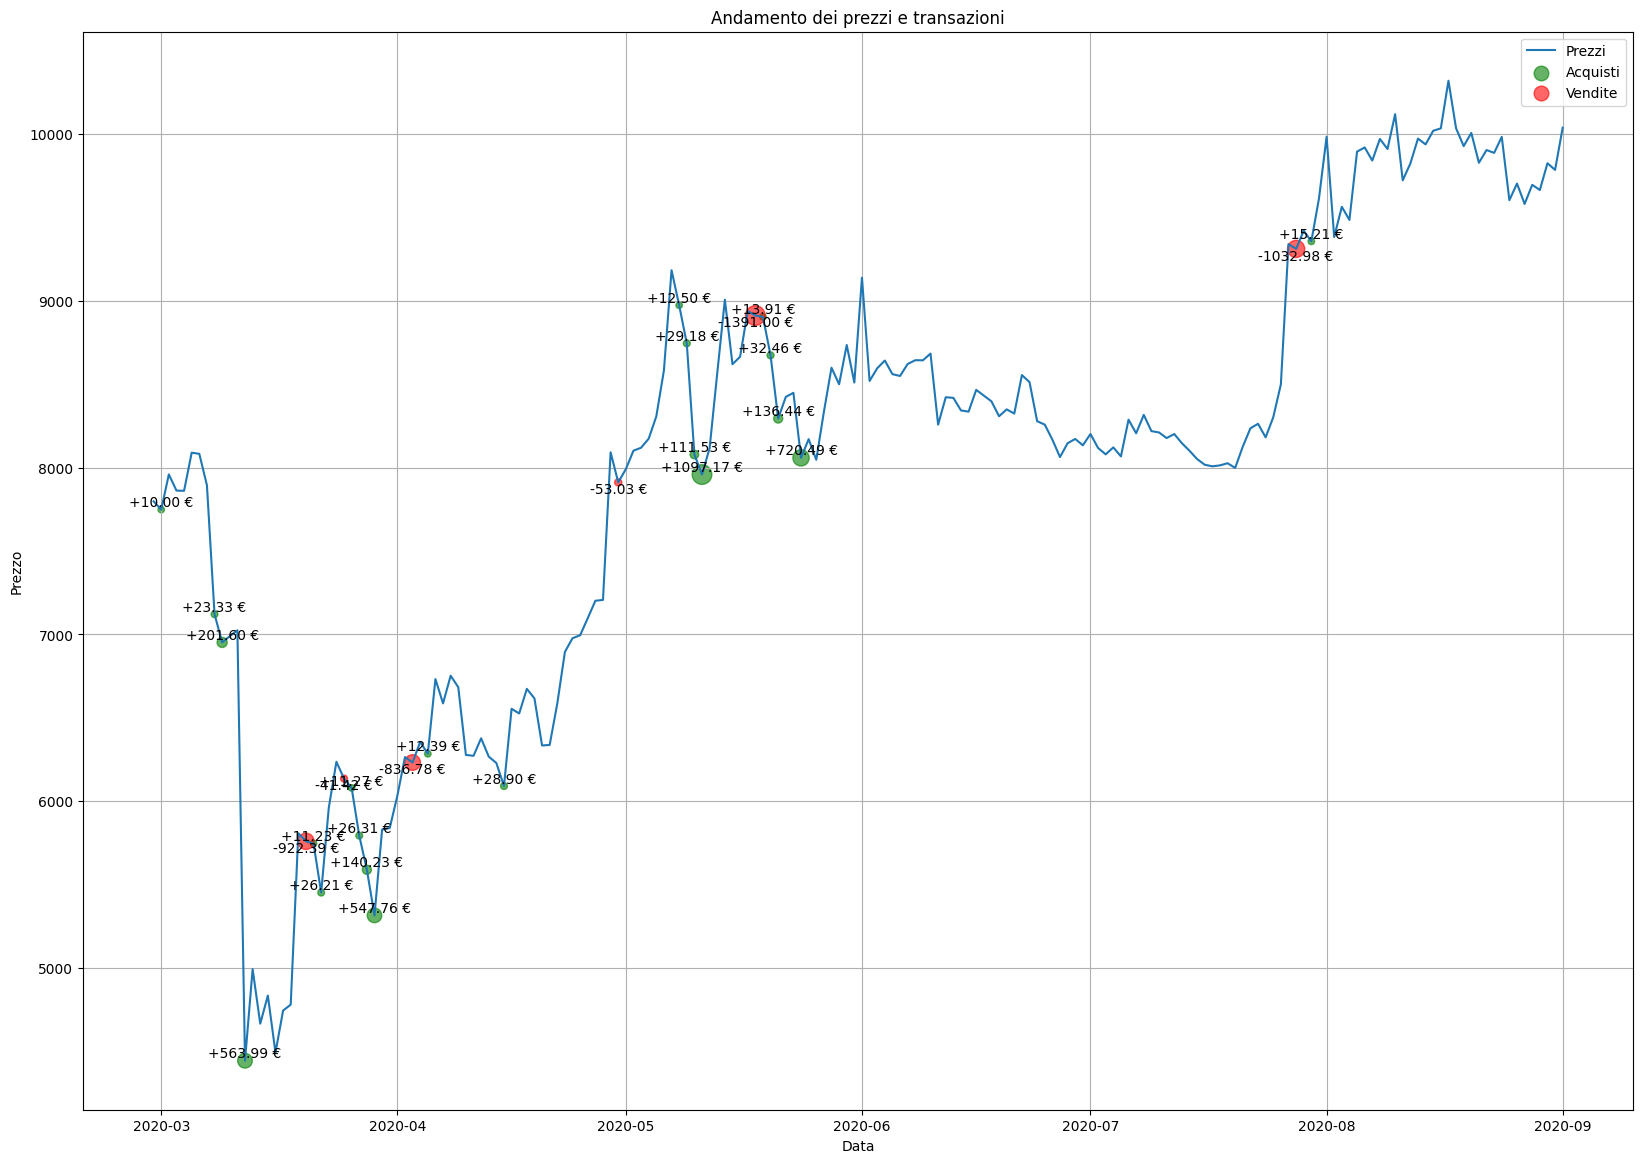

In [117]:
# Inizializzazione dei parametri fissi
liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5


# Inizializzazione dei parametri variabili 
perc_primo_acquisto = 0.01
vendita_immediata = False
perc_sbilanciamento_acquisto = 7/10
soglia_minima_acquisto = 0.01 # Percentuale minima di cui il prezzo dev'essere sotto al prezzo dell'ultimo acquisto per poter acquistare (viene applicato a tutti gli acquisti esclusi i primi acquisti)
soglia_minima_vendita = 0.1 # Percentuale minima di cui il prezzo dev'essere sopra alla media pesata di acquisto per poter vendere
perc_stop_loss = 0.001 # Utile solo in caso di vendita_immediata = False: per vendere, l'algoritmo aspetta che il prezzo scenda almeno di una percentuale perc_stop_loss rispetto al massimo mai raggiunto durante una salita (se vende in questo modo, viene ricalcolato da capo da lì in poi; si aggiorna solo durante le salite, non durante le discese); se perc_stop_loss = 0, semplicemente vende non appena il prezzo scende rispetto al massimo
compra_pure = True # Se è True, nel caso ci fosse bisogno di un acquisto che è superiore alla somma tra liquidità mobile e liquidità fissa, compra con tutto quello che ha (quindi prima fa una ricarica della liquidità mobile con la liquidità fissa che ha, e se anche questa non basta compra con tutta la liquidità mobile rimasta; anche se così facendo non rispetterà la percentuale di sbilanciamento richiesta); se è False, in questi casi non fa niente
vendita_immediata_dinamica = False
tempo_rsi = 14
soglia_rsi = 50
metodo = 'salite_discese_consecutive' # Scegliere tra 'rsi' e 'salite_discese_consecutive'
tempo_salite_discese_consecutive = 14
soglia_salite_consecutive = 2
# Inizializzazione dei coefficienti come liste
coefficienti_acquisto = [1, 0.90625, -1.41667, 0.617188, -0.114583, 0.0078125]
# coefficienti_vendita = [1, 0.90625, -1.41667, 0.617188, -0.114583, 0.0078125]


# Inizio strategia
liquidita_mobile = liquidita_mobile_iniziale
liquidita_fissa = liquidita_fissa_iniziale
bitcoin = bitcoin_iniziali

ultima_azione_effettiva = None
ultimi_acquisti = []
transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
giorni_acquisto = []
giorni_vendita = []

prezzo_massimo = 0
in_salita = False

valori_portafoglio = [] # Solo per debug
rapporti_valori_portafoglio = []

def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
    global transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva
    ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
    nuova_transazione = pd.DataFrame({
        'Data': [dati['Timestamp'].iloc[i]],
        'Numero giorno': i,
        'Prezzo': [dati['Price'].iloc[i]],
        'Ultima Azione': [ultima_azione],
        'Azione Attuale': [azione],
        '% acquisto/vendita di LM': [perc],
        'Quantità in € Comprata/Venduta': [quantita_euro],
        'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
        'Liquidità Mobile': [liquidita_mobile],
        'Liquidità Fissa': [liquidita_fissa],
        'Bitcoin Posseduti': [bitcoin],
        'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
    })
    transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
    if azione != "-":
        ultima_azione_effettiva = azione

def primo_acquisto(i):
    global liquidita_mobile, bitcoin, ultimi_acquisti
    quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
    bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
    liquidita_mobile -= quantita_primo_acquisto
    bitcoin += bitcoin_acquistati
    ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
    giorni_acquisto.append(i)
    aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

def calcola_prezzo_medio_pesato():
    return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

def calculate_rsi(prices):
    if len(prices) < 2:
        raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

    # Calcola le variazioni di prezzo
    price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
    
    # Separa i guadagni e le perdite
    gains = [max(change, 0) for change in price_changes]
    losses = [abs(min(change, 0)) for change in price_changes]

    # Calcola la media dei guadagni e delle perdite
    avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
    avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

    rsi = 100 * avg_gain / (avg_gain + avg_loss)

    return rsi

def lunghezza_media_salite_discese_consecutive(prices):
    if len(prices) < 1:
        raise ValueError("La lista dei prezzi deve contenere almeno 1 elemento per calcolare il numero medio di salite e discese consecutive.")

    up_lengths = []
    down_lengths = []

    current_trend = None
    count = 0

    for i in range(1, len(prices)):
        if prices[i] > prices[i-1]:  # Salita
            if current_trend == 'up':
                count += 1
            else:
                if current_trend == 'down':
                    down_lengths.append(count)
                current_trend = 'up'
                count = 1
        elif prices[i] < prices[i-1]:  # Discesa
            if current_trend == 'down':
                count += 1
            else:
                if current_trend == 'up':
                    up_lengths.append(count)
                current_trend = 'down'
                count = 1

    # Aggiungi l'ultima sequenza
    if current_trend == 'up':
        up_lengths.append(count)
    elif current_trend == 'down':
        down_lengths.append(count)

    return np.mean(up_lengths), np.mean(down_lengths)


def mappatura_perc_prima_vendita_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto):
    # perc_prima_vendita_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_salite ** i for i in range(len(coefficienti_acquisto)))
    perc_primo_acquisto_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_discese ** i for i in range(len(coefficienti_acquisto)))

    # if lunghezza_media_salite == 0:
    #     perc_prima_vendita_risultante = 1
    # else:
    #     perc_prima_vendita_risultante = 2**(-lunghezza_media_salite+1)

    # if lunghezza_media_discese == 0:
    #     perc_primo_acquisto_risultante = 1
    # else:
    #     perc_primo_acquisto_risultante = 2**(-lunghezza_media_discese+1)

    return perc_primo_acquisto_risultante


# Primo acquisto al giorno 1
primo_acquisto(1)

for i in range(2, len(dati)):
    if vendita_immediata_dinamica:
        if metodo == 'rsi':
            if i < tempo_rsi:
                dati_parziali = dati[:i]
            else:
                dati_parziali = dati[i-tempo_rsi:i]

            rsi = calculate_rsi(dati_parziali['Price'])

            if rsi > soglia_rsi:
                vendita_immediata = False
            else:
                vendita_immediata = True
        elif metodo == 'salite_discese_consecutive':
            if i < tempo_salite_discese_consecutive:
                dati_parziali = dati[:i]
            else:
                dati_parziali = dati[i-tempo_salite_discese_consecutive:i]

            salite_discese_consecutive = lunghezza_media_salite_discese_consecutive(dati_parziali['Price'])
            lunghezza_media_salite = salite_discese_consecutive[0] if not np.isnan(salite_discese_consecutive[0]) else 0
            lunghezza_media_discese = salite_discese_consecutive[1] if not np.isnan(salite_discese_consecutive[1]) else 0

            perc_primo_acquisto = mappatura_perc_prima_vendita_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto)

            if lunghezza_media_salite > soglia_salite_consecutive:
                vendita_immediata = False
            else:
                vendita_immediata = True

        else:
            raise ValueError("Metodo scelto non valido")


    prezzo_oggi = dati['Price'].iloc[i]
    prezzo_ieri = dati['Price'].iloc[i-1]
    prezzo_laltro_ieri = dati['Price'].iloc[i-2]
    azione = "-"  # Inizializziamo l'azione come nulla
    
    if bitcoin > 0:
        prezzo_medio_pesato = calcola_prezzo_medio_pesato()
        
        # Aggiorna il prezzo massimo se siamo in una salita
        if prezzo_oggi > prezzo_ieri:
            in_salita = True
            if prezzo_ieri < prezzo_laltro_ieri:
                prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
            prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
        else:
            in_salita = False
        
        if vendita_immediata:
            if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita immediata
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                    ultimi_acquisti = []
        else:
            if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                # Vendita con stop-loss
                quantita_venduta = bitcoin
                ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                if ricavo >= min_vendita:
                    liquidita_mobile += ricavo
                    bitcoin = 0
                    giorni_vendita.append(i)
                    azione = 'Vendita (Stop-Loss)'
                    aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                    print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                    valori_portafoglio.append(bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa) # Solo per debug
                    if len(valori_portafoglio) > 1:
                        print('Rapporti portafoglio:', valori_portafoglio[-1] / valori_portafoglio[-2])
                        rapporti_valori_portafoglio.append(valori_portafoglio[-1] / valori_portafoglio[-2])
                    ultimi_acquisti = []
    
    if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
        if not ultimi_acquisti:
            if prezzo_oggi < prezzo_ieri:
                # Primo acquisto dopo una vendita
                primo_acquisto(i)
                azione = 'Primo Acquisto'
                # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
        elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
            # Calcolo del prezzo desiderato di acquisto
            ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
            A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

            # Calcolo della quantità da acquistare
            S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
            P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
            quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)
            # print(i, A, S, P, quantita_da_acquistare_euro)

            if quantita_da_acquistare_euro >= min_acquisto:
                if quantita_da_acquistare_euro > liquidita_mobile:
                    # Usa la liquidità fissa se necessario
                    liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                    liquidita_mobile += liquidita_aggiuntiva
                    liquidita_fissa -= liquidita_aggiuntiva

                if quantita_da_acquistare_euro <= liquidita_mobile:
                    # Acquisto
                    bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                    vecchia_liquidita_mobile = liquidita_mobile
                    liquidita_mobile -= quantita_da_acquistare_euro
                    bitcoin += bitcoin_acquistati
                    ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                    giorni_acquisto.append(i)
                    azione = 'Acquisto'
                    aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
    
    if azione == "-":
        # Se non è stata effettuata nessuna azione, aggiungiamo comunque una riga alla tabella
        aggiorna_transazioni(i, azione, 0, 0, 0)

    # print(i, prezzo_massimo)

# Grafico
# plt.figure(figsize=(20, 7))
# plt.grid(True)
# plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
# plt.scatter(dati['Timestamp'].iloc[giorni_acquisto], dati['Price'].iloc[giorni_acquisto], color='green', label='Acquisti')
# plt.scatter(dati['Timestamp'].iloc[giorni_vendita], dati['Price'].iloc[giorni_vendita], color='red', label='Vendite')
# plt.legend()
# plt.show()

etichette = True

# Preparazione dei dati per il grafico
acquisti = transazioni[transazioni['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
vendite = transazioni[transazioni['Azione Attuale'].isin(['Vendita', 'Vendita (Stop-Loss)'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
max_vendita = vendite['Quantità in € Comprata/Venduta'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['Data'], acquisti['Prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"+{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['Data'], vendite['Prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['Data'], row['Prezzo'], f"-{row['Quantità in € Comprata/Venduta']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [118]:
# Possibili generalizzazioni della strategia:
# - Aggiungere un vincolo che fa comprare non solo se il prezzo è sceso ancora, ma se è sceso almeno di una certa percentuale (il caso attuale corrisponderebbe a una percentuale sempre pari a 0)
# - Permettere una vendita iniziale e varie vendite successive in modo analogo a quello che faccio con gli acquisti (il caso attuale corrisponderebbe a una vendita iniziale del 100%)

In [119]:
transazioni['Liquidità Fissa']

0      0
1      0
2      0
3      0
4      0
      ..
180    0
181    0
182    0
183    0
184    0
Name: Liquidità Fissa, Length: 185, dtype: object

In [120]:
# valori_portafoglio.insert(0, liquidita_fissa_iniziale+liquidita_mobile_iniziale)
# valori_portafoglio

In [121]:
# rapporti_valori_portafoglio.insert(0, valori_portafoglio[1]/(valori_portafoglio[0]))
# rapporti_valori_portafoglio

In [122]:
# np.mean(rapporti_valori_portafoglio)

In [123]:
# np.std(rapporti_valori_portafoglio)

1.0203465480103417
1.0269233215485742
1.0164702041460354
1.0291360461284413
1.0469188131241893
1.0627922802034893
1.0039183003773968
1.06786269528546
1.0193691621316008
1.0214561977672354
1.0493727954586933
1.0853941068367645
1.0545864013051391
1.0424693181890266
1.0226364174171985
1.0988241961716416
1.0708156053437015
1.068184827026243
1.0355433057703247
1.0985943097579647
1.0262903518764188
1.0667922539439683
1.0571016066794703
1.0094956753983229


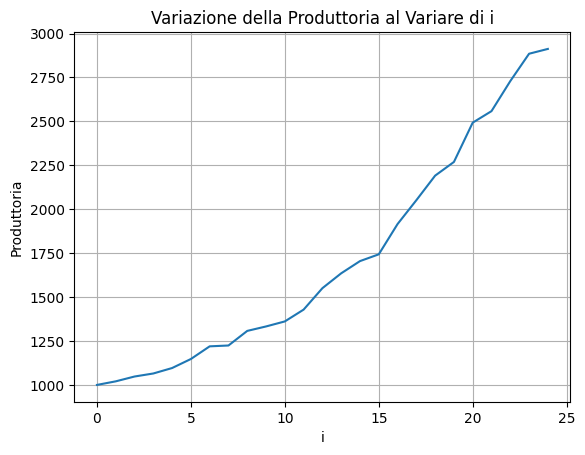

[1000,
 1020.3465480103417,
 1047.817666213402,
 1065.075437083759,
 1096.1075241489011,
 1147.5355882384613,
 1219.5919644386065,
 1224.3706920931365,
 1307.4597872871009,
 1332.784187887613,
 1361.3806690039737,
 1428.595838316126,
 1550.5895039598504,
 1635.2306048825394,
 1704.6777337537303,
 1743.2655304967836,
 1915.5423452618586,
 2051.1926360030707,
 2191.0528510864438,
 2268.930112531551,
 2492.6337108656603,
 2558.1659282233422,
 2729.031596532043,
 2884.8636853730623,
 2912.2574144977743]

In [124]:
# Inizializza la produttoria e la lista per memorizzare i valori
produttoria = 1000
valori = [produttoria]

# Calcola la produttoria per 100 volte
for i in range(1, 25):
    cas = random.uniform(1, 1.1)
    print(cas)
    produttoria *= cas
    valori.append(produttoria)

# Crea il grafico
plt.plot(valori)
plt.title('Variazione della Produttoria al Variare di i')
plt.xlabel('i')
plt.ylabel('Produttoria')
plt.grid()
plt.show()

valori

In [125]:
transazioni[-90:-30]

,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
95,2020-06-04,96,8642.152344,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.402851
96,2020-06-05,97,8560.423828,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1438.327047
97,2020-06-06,98,8549.510742,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1437.115169
98,2020-06-07,99,8621.272461,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1445.084178
99,2020-06-08,100,8644.083984,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.617356
100,2020-06-09,101,8643.343750,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1447.535154
101,2020-06-10,102,8683.817383,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1452.029678
102,2020-06-11,103,8257.708984,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1404.711113
103,2020-06-12,104,8422.061523,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1422.962165
104,2020-06-13,105,8418.423828,Acquisto,-,0.00,0.000000,0.000000,487.707519,0,0.111048,1422.558205


In [126]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [127]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale+liquidita_fissa_iniziale, bitcoin_iniziali, dati['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [128]:
valore_iniziale = liquidita_fissa_iniziale+liquidita_mobile_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = liquidita_mobile + bitcoin * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [129]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.5217805621177982
Punteggio rendimento: 15.2%
Valore finale del portafoglio in euro: 1521.7805621177981


### Strategia 2: compravendita continua

In [130]:
# def calcola_percentuale_acquisto(prezzi, giorni, min_giorni_passati, denominatore_max_drawdown, 
#                                  perc_acquisto_fisso):
#     if len(prezzi) < min_giorni_passati:
#         return perc_acquisto_fisso
    
#     ultimi_giorni = prezzi[-giorni:]
#     massimo = max(ultimi_giorni)
#     minimo = min(ultimi_giorni)
#     discesa_attuale = (ultimi_giorni.iloc[-2] - ultimi_giorni.iloc[-1]) / ultimi_giorni.iloc[-2]

#     if denominatore_max_drawdown:
#         max_drawdown = (massimo - minimo) / massimo
#         if max_drawdown == 0:
#             return perc_acquisto_fisso
#         percentuale = discesa_attuale / max_drawdown
#     else:
#         max_discesa_due_giorni = max(
#             [(ultimi_giorni.iloc[i] - ultimi_giorni.iloc[i + 1]) / ultimi_giorni.iloc[i] for i in range(len(ultimi_giorni) - 1)]
#         )
#         if max_discesa_due_giorni == 0:
#             return perc_acquisto_fisso
#         percentuale = discesa_attuale / max_discesa_due_giorni
    
#     return min(1, percentuale)

# def calcola_percentuale_vendita(prezzi, giorni, min_giorni_passati, denominatore_max_drawdown, 
#                                 perc_vendita_fisso):
#     if len(prezzi) < min_giorni_passati:
#         return perc_vendita_fisso
    
#     ultimi_giorni = prezzi[-giorni:]
#     massimo = max(ultimi_giorni)
#     minimo = min(ultimi_giorni)
#     salita_attuale = (ultimi_giorni.iloc[-1] - ultimi_giorni.iloc[-2]) / ultimi_giorni.iloc[-2]

#     if denominatore_max_drawdown:
#         max_drawdown = (massimo - minimo) / massimo
#         if max_drawdown == 0:
#             return perc_vendita_fisso
#         percentuale = salita_attuale / max_drawdown
#     else:
#         max_salita_due_giorni = max(
#             [(ultimi_giorni.iloc[i + 1] - ultimi_giorni.iloc[i]) / ultimi_giorni.iloc[i] for i in range(len(ultimi_giorni) - 1)]
#         )
#         if max_salita_due_giorni == 0:
#             return perc_vendita_fisso
#         percentuale = salita_attuale / max_salita_due_giorni
    
#     return min(1, percentuale)

# def strategia_trading(dati, giorni_acquisto, min_giorni_passati_acquisto, denominatore_acquisto_max_drawdown, 
#                       usa_liquidita_iniziale, giorni_vendita, min_giorni_passati_vendita, 
#                       denominatore_vendita_max_drawdown, liquidita_iniziale, token_iniziali,
#                       perc_acquisto_fisso, perc_vendita_fisso, min_acquisto, min_vendita,
#                       perc_commissione_acquisto, perc_commissione_vendita):

#     liquidita = liquidita_iniziale
#     token = token_iniziali
#     portafoglio = []

#     for i in range(1, len(dati)):
#         prezzo_oggi = dati.iloc[i]
#         prezzo_ieri = dati.iloc[i-1]
        
#         # Decidere se comprare o vendere
#         if prezzo_oggi < prezzo_ieri:
#             percentuale_acquisto = calcola_percentuale_acquisto(
#                 dati.iloc[:i+1], giorni_acquisto, min_giorni_passati_acquisto, 
#                 denominatore_acquisto_max_drawdown, perc_acquisto_fisso
#             )
#             if usa_liquidita_iniziale:
#                 da_acquistare = liquidita_iniziale * percentuale_acquisto / prezzo_oggi
#             else:
#                 da_acquistare = liquidita * percentuale_acquisto / prezzo_oggi
            
#             costo_iniziale = da_acquistare * prezzo_oggi
            
#             # Controllo se il costo iniziale senza commissioni supera la soglia minima di acquisto
#             if costo_iniziale >= min_acquisto:
#                 costo_totale = costo_iniziale * (1 + perc_commissione_acquisto)
#                 if liquidita >= costo_totale:
#                     token += da_acquistare
#                     liquidita -= costo_totale

#         elif prezzo_oggi > prezzo_ieri:
#             percentuale_vendita = calcola_percentuale_vendita(
#                 dati.iloc[:i+1], giorni_vendita, min_giorni_passati_vendita, 
#                 denominatore_vendita_max_drawdown, perc_vendita_fisso
#             )
#             da_vendere = token * percentuale_vendita
#             ricavo_iniziale = da_vendere * prezzo_oggi
            
#             # Controllo se il ricavo iniziale senza commissioni supera la soglia minima di vendita
#             if ricavo_iniziale >= min_vendita:
#                 ricavo_totale = ricavo_iniziale * (1 - perc_commissione_vendita)
#                 token -= da_vendere
#                 liquidita += ricavo_totale
        
#         # Calcolo del valore del portafoglio
#         valore_portafoglio = liquidita + token * prezzo_oggi
#         portafoglio.append(valore_portafoglio)
    
#     return portafoglio

In [131]:
# # Inizializzazione dei parametri fissi
# liquidita_iniziale = 1000
# bitcoin_iniziali = 0
# perc_commissione_acquisto = 0.001
# perc_commissione_vendita = 0.001
# min_acquisto = 5
# min_vendita = 5

# # Inizializzazione dei parametri variabili (questi influenzano le metriche del trading)
# giorni_acquisto = 5
# min_giorni_passati_acquisto = 3
# denominatore_acquisto_max_drawdown = False
# usa_liquidita_iniziale = True
# perc_acquisto_fisso = 0.05
# giorni_vendita = 5
# min_giorni_passati_vendita = 3
# denominatore_vendita_max_drawdown = False
# perc_vendita_fisso = 0.05

# # Variabili per il tracciamento del portafoglio e delle transazioni
# transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', 
#                                     '% acquisto/vendita di Liquidità', 'Quantità in € Comprata/Venduta', 
#                                     'Quantità di Bitcoin Comprati/Venduti', 'Liquidità', 
#                                     'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
# giorni_acquisto = []
# giorni_vendita = []

# # Inizializzazione dello stato iniziale del portafoglio
# liquidita_mobile = liquidita_iniziale
# bitcoin = bitcoin_iniziali

# # Funzione per aggiornare il DataFrame delle transazioni
# def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
#     global transazioni, liquidita_mobile, bitcoin
#     nuova_transazione = pd.DataFrame({
#         'Data': [dati['Timestamp'].iloc[i]],
#         'Numero giorno': i,
#         'Prezzo': [dati['Price'].iloc[i]],
#         'Ultima Azione': [transazioni['Azione Attuale'].iloc[-1] if not transazioni.empty else "-"],
#         'Azione Attuale': [azione],
#         '% acquisto/vendita di Liquidità': [perc],
#         'Quantità in € Comprata/Venduta': [quantita_euro],
#         'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
#         'Liquidità': [liquidita_mobile],
#         'Bitcoin Posseduti': [bitcoin],
#         'Valore Totale del Portafoglio': [liquidita_mobile + bitcoin * dati['Price'].iloc[i]]
#     })
#     transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)

# # Esecuzione della strategia di trading
# valori_portafoglio = strategia_trading(
#     dati['Price'], giorni_acquisto, min_giorni_passati_acquisto, denominatore_acquisto_max_drawdown, 
#     usa_liquidita_iniziale, giorni_vendita, min_giorni_passati_vendita, 
#     denominatore_vendita_max_drawdown, liquidita_iniziale, bitcoin_iniziali,
#     perc_acquisto_fisso, perc_vendita_fisso, min_acquisto, min_vendita, 
#     perc_commissione_acquisto, perc_commissione_vendita
# )

# # Aggiorna le transazioni in base al portafoglio risultante
# for i in range(1, len(dati)):
#     prezzo_oggi = dati['Price'].iloc[i]
#     valore_portafoglio_oggi = liquidita_mobile + bitcoin * prezzo_oggi
#     aggiorna_transazioni(i, "-", 0, 0, 0)  # Se non c'è stata azione, aggiorniamo comunque

# # Preparazione dei dati per il grafico
# acquisti = transazioni[transazioni['Azione Attuale'].isin(['Acquisto'])]
# vendite = transazioni[transazioni['Azione Attuale'].isin(['Vendita'])]

# # Calcolo delle dimensioni dei punti per il grafico
# max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
# max_vendita = vendite['Quantità in € Comprata/Venduta'].max()

# def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#     return min_size + (max_size - min_size) * (quantita / max_quantita)

# dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
# dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))

# # Creazione del grafico delle transazioni
# plt.figure(figsize=(20, 14))
# plt.grid()
# plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
# if not acquisti.empty:
#     plt.scatter(acquisti['Data'], acquisti['Prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
#     for i, row in acquisti.iterrows():
#         plt.text(row['Data'], row['Prezzo'], f"+{row['Quantità in € Comprata/Venduta']:.2f} €", 
#                  color='black', ha='center', va='bottom')
# if not vendite.empty:
#     plt.scatter(vendite['Data'], vendite['Prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
#     for i, row in vendite.iterrows():
#         plt.text(row['Data'], row['Prezzo'], f"-{row['Quantità in € Comprata/Venduta']:.2f} €", 
#                  color='black', ha='center', va='top')

# plt.xlabel('Data')
# plt.ylabel('Prezzo')
# plt.title('Andamento dei prezzi e transazioni')
# plt.legend()
# plt.show()

# # Grafico del valore totale del portafoglio nel tempo
# plt.figure(figsize=(20, 7))
# plt.plot(dati['Timestamp'][1:], valori_portafoglio, label='Valore Totale del Portafoglio')
# plt.xlabel('Data')
# plt.ylabel('Valore Totale del Portafoglio')
# plt.title('Andamento del Valore del Portafoglio nel Tempo')
# plt.grid(True)
# plt.legend()
# plt.show()

In [132]:
# transazioni['Liquidità Fissa']

In [133]:
# transazioni[-90:-30]

In [134]:
# def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
#     capitale = capitale_iniziale
#     bitcoin = bitcoin_iniziali
#     comprato = False

#     for i in range(len(lista_prezzi) - 1):
#         # Compra al minimo
#         if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
#             bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
#             bitcoin += bitcoin_acquistati
#             capitale = 0
#             comprato = True
#             # print(f'Bitcoin posseduti: {bitcoin}')
#         # Vende al massimo
#         elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
#             capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
#             capitale += capitale_vendita
#             bitcoin = 0
#             comprato = False
#             # print(f'Capitale posseduto: {capitale}')

#     # Vende i bitcoin rimasti all'ultimo prezzo
#     if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
#         capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
#         bitcoin = 0
#         # print(f'Capitale posseduto: {capitale}')
#         # print(f'Bitcoin posseduti: {bitcoin}')

#     valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
#     valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

#     rendimento = valore_finale / valore_iniziale

#     return [rendimento, valore_finale]

In [135]:
# rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale+liquidita_fissa_iniziale, bitcoin_iniziali, dati['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
# print('Rendimento ideale:', rendimento_ideale)
# print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

In [136]:
# valore_iniziale = liquidita_fissa_iniziale+liquidita_mobile_iniziale + bitcoin_iniziali * dati['Price'][0]
# valore_finale = liquidita_mobile + bitcoin * dati['Price'].iloc[-1]
# rendimento = valore_finale / valore_iniziale

In [137]:
# print(f"Rendimento del portafoglio: {rendimento}")
# print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
# print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

### Strategia 3: media pesata forzata bidirezionale

In [138]:
def strategia_media_pesata_forzata_bidirezionale(btc_data,
                      liquidità_iniziale,
                      bitcoin_iniziali,
                      percentuale_sbilanciamento_acquisti, 
                      percentuale_sbilanciamento_vendite,
                      percentuale_primo_acquisto, 
                      percentuale_prima_vendita, 
                      percentuale_commissione_acquisti, 
                      percentuale_commissione_vendite,
                      acquisto_minimo, 
                      vendita_minima,
                      vendi_pure,
                      compra_pure,
                      soglia_minima_vendita):
    
    # Inizializzazione delle variabili
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_portafoglio = []
    transazioni = []

    # Variabili di controllo
    ultima_azione = None
    ultimo_prezzo_acquisto = 0
    ultimo_prezzo_vendita = 0
    somme_acquisto = 0
    somme_vendita = 0
    pesi_acquisto = 0
    pesi_vendita = 0

    # Nuove variabili per il calcolo del prezzo medio pesato
    acquisti_consecutivi = []
    prezzo_medio_pesato_acquisti = 0

    for i in range(1, len(btc_data)):
        azione = "-"
        # ultima_azione = '-'
        quantità_euro = 0
        quantità_bitcoin = 0
        prezzo_oggi = btc_data['Price'].iloc[i]
        prezzo_ieri = btc_data['Price'].iloc[i-1]
        data = btc_data['Timestamp'].iloc[i]

        liquidità_precedente = liquidità
        bitcoin_precedenti = bitcoin

        def esegui_acquisto():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_acquisto, somme_acquisto, pesi_acquisto, somme_vendita, pesi_vendita, acquisti_consecutivi, prezzo_medio_pesato_acquisti
            if quantità_euro >= acquisto_minimo and quantità_euro != 0:
                if quantità_euro > liquidità and compra_pure:
                    quantità_euro = liquidità
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato_acquisti = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                    somme_vendita = 0
                    pesi_vendita = 0
                elif quantità_euro <= liquidità:
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato_acquisti = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                    somme_vendita = 0
                    pesi_vendita = 0
            #     else:
            #         azione = '-'
            # else:
            #     azione = '-'

        def esegui_vendita():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_vendita, somme_vendita, pesi_vendita, somme_acquisto, pesi_acquisto, acquisti_consecutivi, prezzo_medio_pesato_acquisti
            if quantità_euro >= vendita_minima and quantità_euro != 0:
                if quantità_bitcoin > bitcoin and vendi_pure and prezzo_oggi >= prezzo_medio_pesato_acquisti * (1 + soglia_minima_vendita):
                    quantità_bitcoin = bitcoin
                    quantità_euro = quantità_bitcoin * prezzo_oggi * (1 - percentuale_commissione_vendite)
                    bitcoin -= quantità_bitcoin
                    liquidità += quantità_euro
                    azione = "vendita"
                    ultima_azione = "vendita"
                    ultimo_prezzo_vendita = prezzo_oggi
                    somme_vendita += prezzo_oggi * quantità_euro
                    pesi_vendita += quantità_euro
                    acquisti_consecutivi = []
                    somme_acquisto = 0
                    pesi_acquisto = 0
                elif quantità_bitcoin <= bitcoin and prezzo_oggi >= prezzo_medio_pesato_acquisti * (1 + soglia_minima_vendita):
                    if quantità_euro > 0 and quantità_bitcoin > 0:
                        bitcoin -= quantità_bitcoin
                        liquidità += quantità_euro
                        azione = "vendita"
                        ultima_azione = "vendita"
                        ultimo_prezzo_vendita = prezzo_oggi
                        somme_vendita += prezzo_oggi * quantità_euro
                        pesi_vendita += quantità_euro
                        acquisti_consecutivi = []
                        somme_acquisto = 0
                        pesi_acquisto = 0
            #         else:
            #             azione = '-'
            #     else:
            #         azione = '-'
            # else:
            #     azione = '-'

        if ultima_azione is None:  # Caso del primo giorno
            if prezzo_oggi < prezzo_ieri:  # Il prezzo è sceso
                quantità_euro = liquidità * percentuale_primo_acquisto
                esegui_acquisto()
            elif prezzo_oggi > prezzo_ieri:  # Il prezzo è salito
                quantità_bitcoin = bitcoin * percentuale_prima_vendita
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            else:
                azione = '-'

        else:  # Dopo il primo giorno
            if ultima_azione == "acquisto" and prezzo_oggi < ultimo_prezzo_acquisto:
                A = percentuale_sbilanciamento_acquisti * prezzo_oggi + (1 - percentuale_sbilanciamento_acquisti) * ultimo_prezzo_acquisto
                quantità_euro = (somme_acquisto - A * pesi_acquisto) / (A - prezzo_oggi)
                esegui_acquisto()
            elif ultima_azione == "vendita" and prezzo_oggi > ultimo_prezzo_vendita:
                A = percentuale_sbilanciamento_vendite * prezzo_oggi + (1 - percentuale_sbilanciamento_vendite) * ultimo_prezzo_vendita
                quantità_euro = (somme_vendita - A * pesi_vendita) / (A - prezzo_oggi)
                quantità_bitcoin = (quantità_euro / prezzo_oggi)
                esegui_vendita()
            elif ultima_azione == "acquisto" and prezzo_oggi > ultimo_prezzo_acquisto:
                # Cambio di direzione: si vende dopo un acquisto
                quantità_bitcoin = percentuale_prima_vendita * bitcoin
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            elif ultima_azione == "vendita" and prezzo_oggi < ultimo_prezzo_vendita:
                # Cambio di direzione: si compra dopo una vendita
                quantità_euro = percentuale_primo_acquisto * liquidità
                esegui_acquisto()

        valore_totale = liquidità + bitcoin * prezzo_oggi
        valore_portafoglio.append(valore_totale)
        
        transazioni.append({
            'data': data,
            'prezzo': prezzo_oggi,
            'azione': azione,
            'ultima azione': ultima_azione,
            'percentuale_liquidità_usata': round((quantità_euro / liquidità_precedente) * 100, 2) if azione == "acquisto" and liquidità_precedente != 0 else 0,
            'percentuale_token_venduti': round((quantità_bitcoin / bitcoin_precedenti) * 100, 2) if azione == "vendita" and bitcoin_precedenti != 0 else 0,
            'quantità_euro': quantità_euro,
            'quantità_bitcoin': quantità_bitcoin,
            'liquidità_posseduta': liquidità,
            'bitcoin_posseduti': bitcoin,
            'valore_totale_portafoglio': valore_totale
        })

    return pd.DataFrame(transazioni)

In [139]:
percentuale_sbilanciamento_acquisti=0.1
percentuale_sbilanciamento_vendite=0.1
percentuale_primo_acquisto=0.1
percentuale_prima_vendita=0.1
vendi_pure=True
compra_pure=True
soglia_minima_vendita = 0

liquidità_iniziale=1000
bitcoin_iniziali=0
percentuale_commissione_acquisti=0.001
percentuale_commissione_vendite=0.001
acquisto_minimo=0
vendita_minima=0

# Applica la strategia
df_transazioni = strategia_media_pesata_forzata_bidirezionale(dati, 
                      liquidità_iniziale, 
                      bitcoin_iniziali, 
                      percentuale_sbilanciamento_acquisti, 
                      percentuale_sbilanciamento_vendite,
                      percentuale_primo_acquisto, 
                      percentuale_prima_vendita,
                      percentuale_commissione_acquisti, 
                      percentuale_commissione_vendite,
                      acquisto_minimo,
                      vendita_minima,
                      vendi_pure,
                      compra_pure,
                      soglia_minima_vendita)

# Visualizza il valore del portafoglio nel tempo
df_transazioni

,data,prezzo,azione,ultima azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2020-03-01,7748.164551,acquisto,acquisto,10.00,0.0,100.000000,0.012893,900.000000,0.012893,999.900000
1,2020-03-02,7959.358398,vendita,vendita,0.00,10.0,10.262300,0.001289,910.262300,0.011604,1002.623002
2,2020-03-03,7862.485352,acquisto,acquisto,10.00,0.0,91.026230,0.011566,819.236070,0.023170,1001.407857
3,2020-03-04,7861.055176,acquisto,acquisto,1.23,0.0,10.114026,0.001285,809.122045,0.024455,1001.364606
4,2020-03-05,8089.786133,vendita,vendita,0.00,10.0,19.783619,0.002446,828.905664,0.022010,1006.958235
...,...,...,...,...,...,...,...,...,...,...,...
180,2020-08-28,9695.468750,vendita,vendita,0.00,10.0,67.758088,0.006989,600.651864,0.062898,1210.474657
181,2020-08-29,9664.351562,acquisto,acquisto,10.00,0.0,60.065186,0.006209,540.586677,0.069107,1208.457392
182,2020-08-30,9824.922852,vendita,vendita,0.00,10.0,67.896725,0.006911,608.483403,0.062196,1219.553932
183,2020-08-31,9785.023438,acquisto,acquisto,10.00,0.0,60.848340,0.006212,547.635063,0.068408,1217.011501


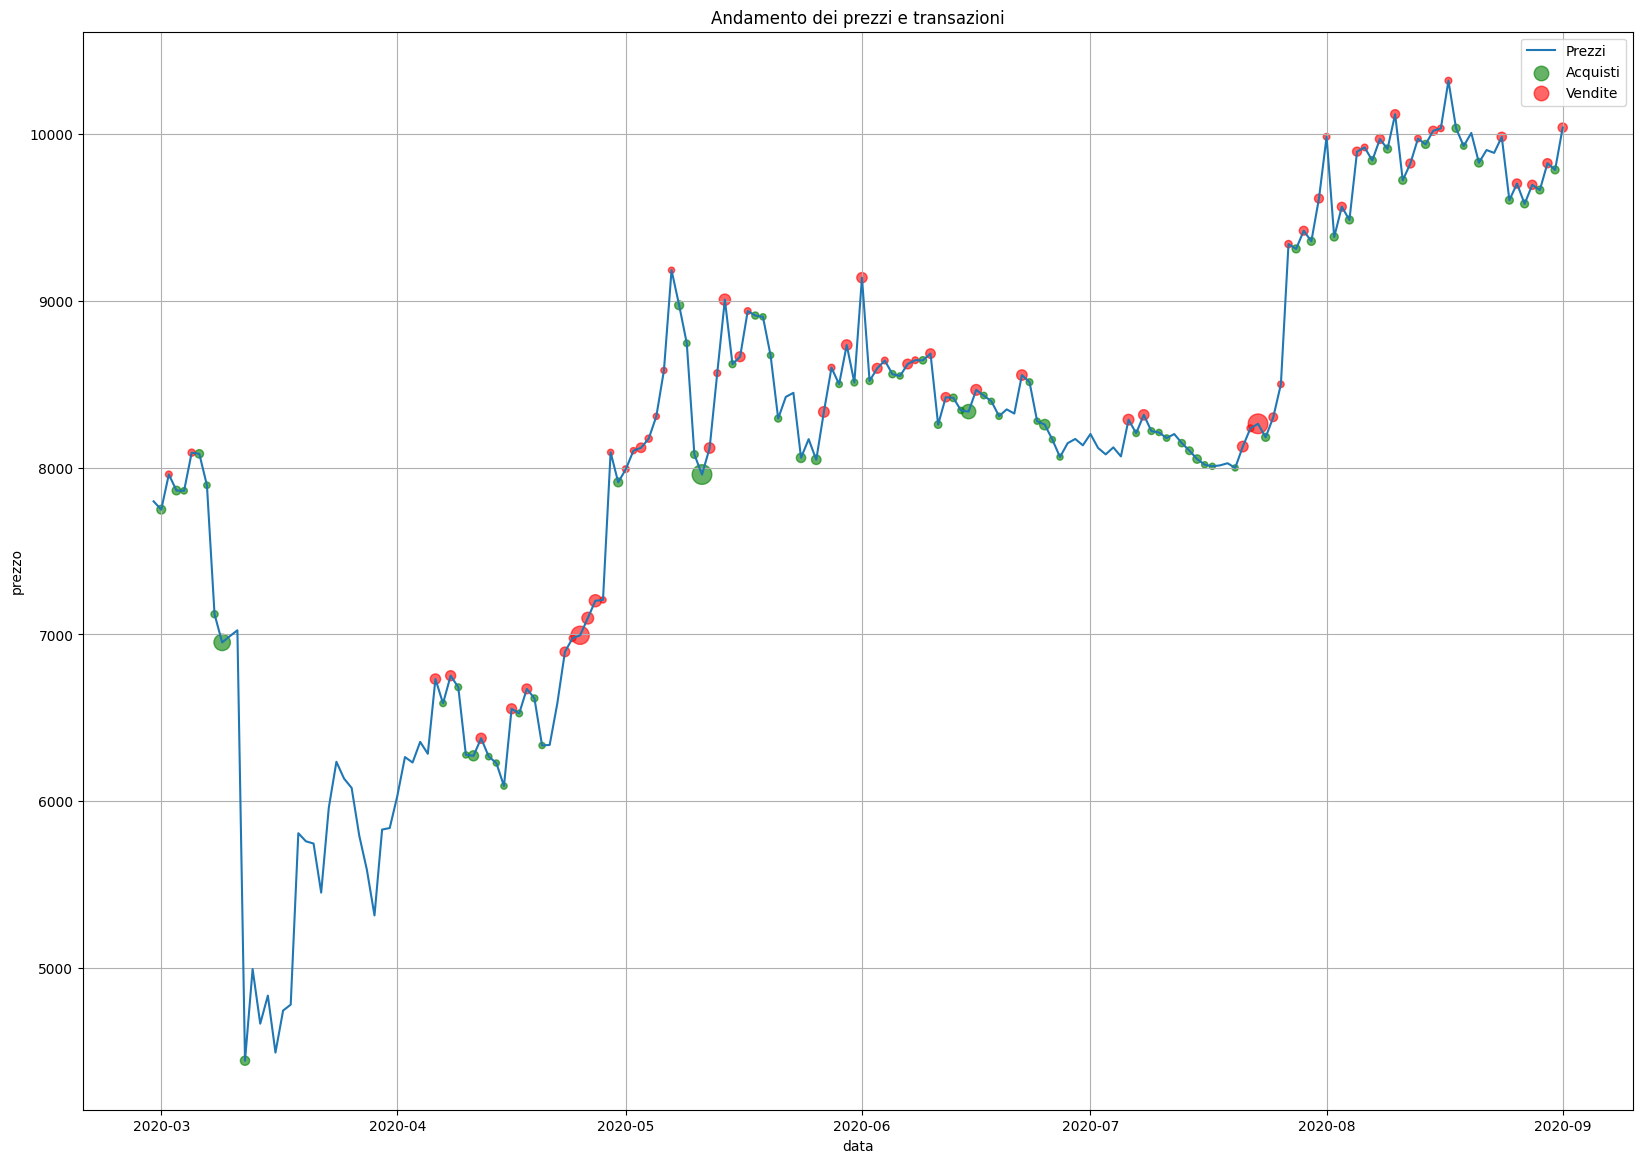

In [140]:
etichette = False

# Preparazione dei dati per il grafico
acquisti = df_transazioni[df_transazioni['azione'].isin(['acquisto'])]
vendite = df_transazioni[df_transazioni['azione'].isin(['vendita'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['quantità_euro'].max()
max_vendita = vendite['quantità_euro'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['data'], row['prezzo'], f"+{row['quantità_euro']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['data'], row['prezzo'], f"-{row['quantità_euro']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('data')
plt.ylabel('prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [141]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [142]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, dati['Price'], acquisto_minimo, vendita_minima, percentuale_commissione_acquisti, percentuale_commissione_vendite)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [143]:
valore_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = df_transazioni['liquidità_posseduta'].iloc[-1] + df_transazioni['bitcoin_posseduti'].iloc[-1] * df_transazioni['prezzo'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [144]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {liquidita_mobile + bitcoin * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.2343557344429488
Punteggio rendimento: 12.33%
Valore finale del portafoglio in euro: 1521.7805621177981


##### Grafico andamenti

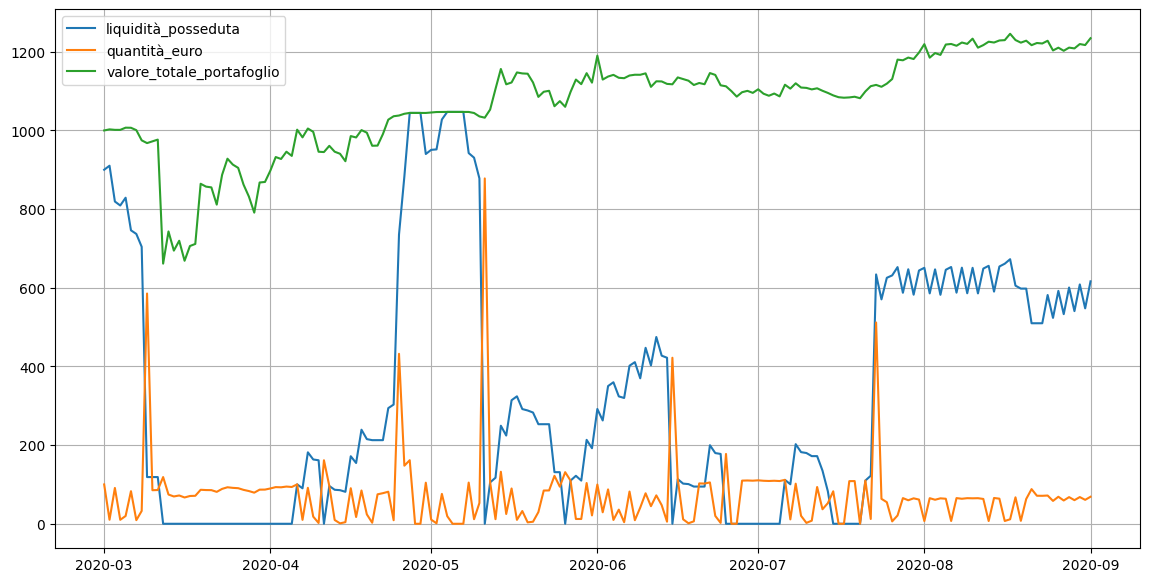

In [145]:
# Creiamo un DataFrame per memorizzare i dati del portafoglio
portafoglio = df_transazioni[['data', 'liquidità_posseduta', 'quantità_euro', 'valore_totale_portafoglio']]

# Creiamo un grafico multi-linea
plt.figure(figsize=(14,7))

# Grafico della liquidità
plt.plot(portafoglio['data'], portafoglio['liquidità_posseduta'], label='liquidità_posseduta')

# Grafico della quantità in euro comprata/venduta
plt.plot(portafoglio['data'], portafoglio['quantità_euro'], label='quantità_euro')

# Grafico del valore totale del portafoglio
plt.plot(portafoglio['data'], portafoglio['valore_totale_portafoglio'], label='valore_totale_portafoglio')

# Aggiungiamo una legenda
plt.legend()

plt.grid()

# Mostriamo il grafico
plt.show()

## Generazione dataset sintetici

In [146]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [147]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [148]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,31472.685547
2,2021-01-11,29247.208984
3,2021-01-12,27786.228516
4,2021-01-13,30682.929688
...,...,...
1054,2023-11-29,34379.074219
1055,2023-11-30,34499.992188
1056,2023-12-01,34625.015625
1057,2023-12-02,35518.437500


In [149]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

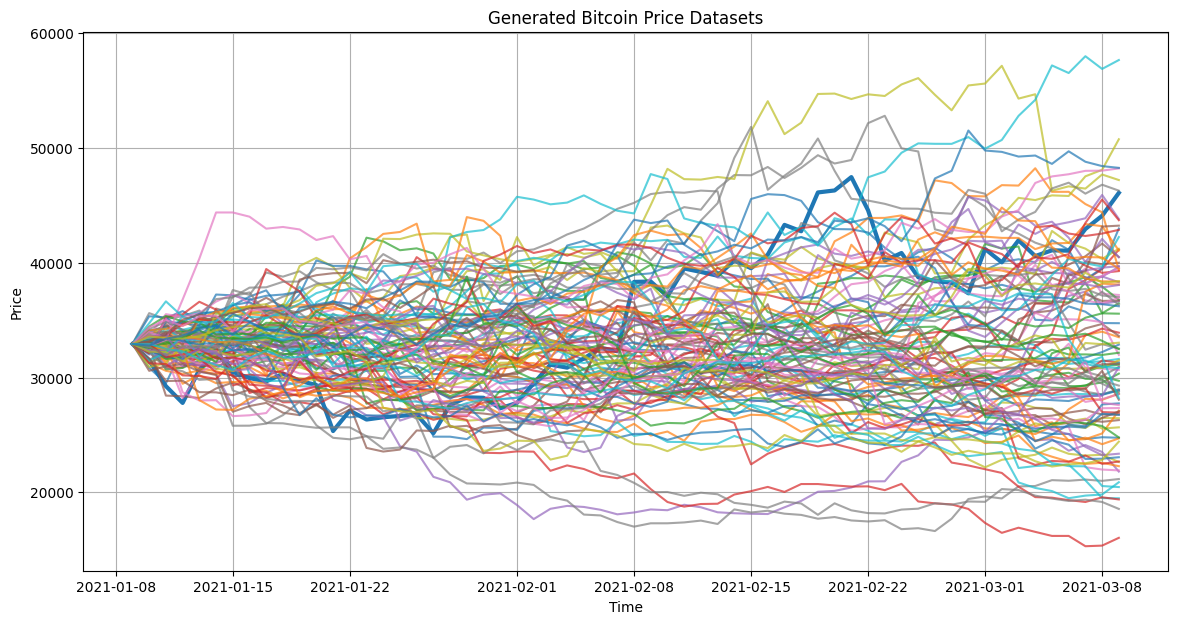

In [150]:
# Calcola le variazioni giornaliere
dati['Daily Change'] = dati['Price'].pct_change().dropna()

# Estrai la distribuzione delle variazioni giornaliere
daily_changes = dati['Daily Change'].values[1:]

# Numero di dataset da generare
n_dataset = 100

# Numero di giorni che dura ogni dataset
lunghezza_dataset = 60

# Fissa il random_state
random_state = 42
np.random.seed(random_state)

# Lista per conservare i dataset generati
generated_datasets = []

# Genera i dataset
for i in range(n_dataset):
    generated_prices = [dati['Price'].iloc[0]]  # Il primo prezzo coincide con il primo dato originale
    for _ in range(lunghezza_dataset - 1):
        change = np.random.choice(daily_changes)
        new_price = generated_prices[-1] * (1 + change)
        generated_prices.append(new_price)
    generated_datasets.append(generated_prices)

# Converte i dataset generati in DataFrame
generated_dfs = [pd.DataFrame({'Timestamp': dati['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in generated_datasets]

# Plotting
plt.figure(figsize=(14, 7))

# Plot del dataset originale
plt.plot(dati['Timestamp'].iloc[:lunghezza_dataset], dati['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# Plot dei dataset generati
for i, df in enumerate(generated_dfs):
    plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

plt.title('Generated Bitcoin Price Datasets')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.yscale('log')
plt.grid()
# plt.legend()
plt.show()

In [151]:
# Crea un DataFrame combinato
combined_df = pd.DataFrame()
combined_df['Timestamp'] = dati['Timestamp'].iloc[:lunghezza_dataset]
for i, prices in enumerate(generated_datasets):
    combined_df[f'Generated Dataset {i+1}'] = prices

# Salva il DataFrame combinato in un file CSV
# combined_df.to_csv('generated_datasets_09_01_2021_03_12_2023_60.csv', index=False)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_18004\2406152257.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'Generated Dataset {i+1}'] = prices


In [152]:
print('Fattore di ritorno medio dei prezzi generati:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in generated_dfs]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(1000, 0, df['Price'], 5, 5, 0.001, 0.001)[0] for df in generated_dfs]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(1000, 0, df['Price'], 1, 1, 0.001, 0.001)[0] for df in generated_dfs])

print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

Fattore di ritorno medio dei prezzi generati: 0.9938671717603585
Media dei fattori di rendimento massimi ottenibili: 1.8615805945919237
Punteggio percentuale considerato "sufficiente": 54.9%


In [153]:
# Leggi il file CSV
loaded_df = pd.read_csv('generated_datasets_09_01_2021_03_12_2023_60.csv')

# Lista per conservare i dataset letti
read_dfs = []

# Separazione dei dataset dal DataFrame caricato
for column in loaded_df.columns[1:]:  # Ignora la colonna 'Timestamp'
    df = pd.DataFrame({
        'Timestamp': loaded_df['Timestamp'],
        'Price': loaded_df[column]
    })
    read_dfs.append(df)

# Controllo del primo dataset per verificare
read_dfs[0]

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,32867.007988
2,2021-01-11,33622.276971
3,2021-01-12,34120.684437
4,2021-01-13,33468.657388
5,2021-01-14,34353.574928
6,2021-01-15,33092.814400
7,2021-01-16,32964.017763
8,2021-01-17,36168.925059
9,2021-01-18,36280.266798


## Estrazione di N periodi casuali di lunghezza L tra 2 date (in alternativa ai dataset sintetici)

In [154]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [155]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,31472.685547
2,2021-01-11,29247.208984
3,2021-01-12,27786.228516
4,2021-01-13,30682.929688
...,...,...
1054,2023-11-29,34379.074219
1055,2023-11-30,34499.992188
1056,2023-12-01,34625.015625
1057,2023-12-02,35518.437500


In [173]:
def estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state):
    # Filtra i dati tra start_date e end_date
    dati_filtrati = dati[(dati['Timestamp'] >= pd.to_datetime(start_date)) & 
                         (dati['Timestamp'] <= pd.to_datetime(end_date))]
    
    # Calcola il numero massimo di periodi non sovrapposti
    num_max_periodi = len(dati_filtrati) - L + 1
    
    # Controlla se è possibile estrarre N periodi diversi
    if num_max_periodi < N:
        raise ValueError(f"Non è possibile estrarre {N} periodi diversi di lunghezza {L} tra le date {start_date} e {end_date}.")
    
    # Inizializza una lista per i periodi estratti e un set per memorizzare gli estremi
    periodi_estratti = []
    estremi_estratti = set()
    
    # Inizializza il generatore di numeri casuali con il seed dato
    rng = np.random.RandomState(random_state)
    
    while len(periodi_estratti) < N:
        # Seleziona un indice casuale per l'inizio del periodo
        indice_inizio = rng.randint(0, len(dati_filtrati) - L + 1)
        
        # Determina gli estremi del periodo
        estremo_inizio = dati_filtrati.iloc[indice_inizio]['Timestamp']
        estremo_fine = dati_filtrati.iloc[indice_inizio + L - 1]['Timestamp']
        
        # Controlla se gli estremi sono già stati utilizzati
        if (estremo_inizio, estremo_fine) not in estremi_estratti:
            # Aggiungi gli estremi al set
            estremi_estratti.add((estremo_inizio, estremo_fine))
            
            # Estrai il periodo e aggiungilo alla lista dei periodi estratti
            periodo = dati_filtrati.iloc[indice_inizio:indice_inizio + L]

            periodo = periodo.reset_index(drop=True)

            periodi_estratti.append(periodo)
    
    return periodi_estratti

In [174]:
# Esempio di utilizzo:
start_date = dati['Timestamp'].iloc[0]
end_date = dati['Timestamp'].iloc[-1]
N = 100 # Numero di periodi da estrarre
L = 30 # Lunghezza di ogni periodo in giorni
random_state = 8

periodi_casuali_esistenti = estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state)

In [175]:
periodi_casuali_esistenti[0]

,Timestamp,Price
0,2022-04-05,41772.113281
1,2022-04-06,39647.105469
2,2022-04-07,40040.984375
3,2022-04-08,38879.828125
4,2022-04-09,39334.453125
5,2022-04-10,38778.593750
6,2022-04-11,36335.328125
7,2022-04-12,37065.078125
8,2022-04-13,37784.144531
9,2022-04-14,36902.015625


## Testo il mio algoritmo di trading sui dataset generati

### Seleziono solo il periodo che voglio

In [159]:
# data_inizio = '2020-02-29'
# data_fine = '2020-09-01'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# for i in range(len(generated_dfs)):
#     generated_dfs[i] = generated_dfs[i][indice_inizio:indice_fine + 1].reset_index(drop=True)

# generated_dfs[0]

In [160]:
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Visualizzo i dati nel nuovo periodo selezionato

In [161]:
# # Plotting
# plt.figure(figsize=(14, 7))

# # Plot del dataset originale
# plt.plot(dati['Price'].values, label='Original', linewidth=3)

# # Plot dei dataset generati
# for i, df in enumerate(generated_dfs):
#     plt.plot(df['Price'].values, label=f'Generated Dataset {i+1}', alpha=0.7)

# plt.title('Generated Bitcoin Price Datasets')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.yscale('log')
# plt.grid()
# # plt.legend()
# plt.show()

### Strategia di trading

#### Media pesata forzata (con variabili statiche)

In [162]:
# Supponiamo che la tua funzione di trading sia implementata come `strategia_media_pesata_forzata_statica`
def strategia_media_pesata_forzata_statica(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure):

    liquidita_mobile = liquidita_mobile_iniziale
    liquidita_fissa = liquidita_fissa_iniziale
    bitcoin = bitcoin_iniziali

    ultima_azione_effettiva = None
    ultimi_acquisti = []
    transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
    giorni_acquisto = []
    giorni_vendita = []

    prezzo_massimo = 0
    in_salita = False

    def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
        nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
        ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
        nuova_transazione = pd.DataFrame({
            'Data': [dati['Timestamp'].iloc[i]],
            'Numero giorno': i,
            'Prezzo': [dati['Price'].iloc[i]],
            'Ultima Azione': [ultima_azione],
            'Azione Attuale': [azione],
            '% acquisto/vendita di LM': [perc],
            'Quantità in € Comprata/Venduta': [quantita_euro],
            'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
            'Liquidità Mobile': [liquidita_mobile],
            'Liquidità Fissa': [liquidita_fissa],
            'Bitcoin Posseduti': [bitcoin],
            'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
        })
        transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
        if azione != "-":
            ultima_azione_effettiva = azione

    def primo_acquisto(i):
        nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
        quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
        bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
        liquidita_mobile -= quantita_primo_acquisto
        bitcoin += bitcoin_acquistati
        ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
        giorni_acquisto.append(i)
        aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

    def calcola_prezzo_medio_pesato():
        return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

    # Primo acquisto al giorno 1
    primo_acquisto(1)

    for i in range(2, len(dati)):
        prezzo_oggi = dati['Price'].iloc[i]
        prezzo_ieri = dati['Price'].iloc[i-1]
        prezzo_laltro_ieri = dati['Price'].iloc[i-2]
        azione = "-"  # Inizializziamo l'azione come nulla
        
        if bitcoin > 0:
            prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
            # Aggiorna il prezzo massimo se siamo in una salita
            if prezzo_oggi > prezzo_ieri:
                in_salita = True
                if prezzo_ieri < prezzo_laltro_ieri:
                    prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
                prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
            else:
                in_salita = False
            
            if vendita_immediata:
                if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita immediata
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                        ultimi_acquisti = []
            else:
                if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita con stop-loss
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita (Stop-Loss)'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                        ultimi_acquisti = []
        
        if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
            if not ultimi_acquisti:
                if prezzo_oggi < prezzo_ieri:
                    # Primo acquisto dopo una vendita
                    primo_acquisto(i)
                    azione = 'Primo Acquisto'
                    # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
            elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
                # Calcolo del prezzo desiderato di acquisto
                ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
                A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

                # Calcolo della quantità da acquistare
                S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
                P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
                quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

                if quantita_da_acquistare_euro >= min_acquisto:
                    if quantita_da_acquistare_euro > liquidita_mobile:
                        # Usa la liquidità fissa se necessario
                        liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                        liquidita_mobile += liquidita_aggiuntiva
                        liquidita_fissa -= liquidita_aggiuntiva

                    if quantita_da_acquistare_euro <= liquidita_mobile:
                        # Acquisto
                        bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile -= quantita_da_acquistare_euro
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                    elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
        if azione == "-":
            # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
            aggiorna_transazioni(i, azione, 0, 0, 0)

    return transazioni

#### Media pesata forzata (con variabili dinamiche)

In [163]:
def strategia_media_pesata_forzata_dinamica(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto):

    liquidita_mobile = liquidita_mobile_iniziale
    liquidita_fissa = liquidita_fissa_iniziale
    bitcoin = bitcoin_iniziali

    ultima_azione_effettiva = None
    ultimi_acquisti = []
    transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
    giorni_acquisto = []
    giorni_vendita = []

    prezzo_massimo = 0
    in_salita = False

    def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
        nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
        ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
        nuova_transazione = pd.DataFrame({
            'Data': [dati['Timestamp'].iloc[i]],
            'Numero giorno': i,
            'Prezzo': [dati['Price'].iloc[i]],
            'Ultima Azione': [ultima_azione],
            'Azione Attuale': [azione],
            '% acquisto/vendita di LM': [perc],
            'Quantità in € Comprata/Venduta': [quantita_euro],
            'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
            'Liquidità Mobile': [liquidita_mobile],
            'Liquidità Fissa': [liquidita_fissa],
            'Bitcoin Posseduti': [bitcoin],
            'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
        })
        transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
        if azione != "-":
            ultima_azione_effettiva = azione

    def primo_acquisto(i):
        nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
        quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
        bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
        liquidita_mobile -= quantita_primo_acquisto
        bitcoin += bitcoin_acquistati
        ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
        giorni_acquisto.append(i)
        aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

    def calcola_prezzo_medio_pesato():
        return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])
    
    def calculate_rsi(prices):
        if len(prices) < 2:
            raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

        # Calcola le variazioni di prezzo
        price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
        
        # Separa i guadagni e le perdite
        gains = [max(change, 0) for change in price_changes]
        losses = [abs(min(change, 0)) for change in price_changes]

        # Calcola la media dei guadagni e delle perdite
        avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
        avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

        rsi = 100 * avg_gain / (avg_gain + avg_loss)

        return rsi

    def mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto):
        perc_primo_acquisto_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_discese ** i for i in range(len(coefficienti_acquisto)))
        return perc_primo_acquisto_risultante

    # Primo acquisto al giorno 1
    primo_acquisto(1)

    for i in range(2, len(dati)):
        if vendita_immediata_dinamica:
            if metodo == 'rsi':
                if i < tempo_rsi:
                    dati_parziali = dati[:i]
                else:
                    dati_parziali = dati[i-tempo_rsi:i]

                rsi = calculate_rsi(dati_parziali['Price'])

                if rsi > soglia_rsi:
                    vendita_immediata = False
                else:
                    vendita_immediata = True
            elif metodo == 'salite_discese_consecutive':
                if i < tempo_salite_discese_consecutive:
                    dati_parziali = dati[:i]
                else:
                    dati_parziali = dati[i-tempo_salite_discese_consecutive:i]

                salite_discese_consecutive = lunghezza_media_salite_discese_consecutive(dati_parziali['Price'])
                lunghezza_media_salite = salite_discese_consecutive[0] if not np.isnan(salite_discese_consecutive[0]) else 0
                lunghezza_media_discese = salite_discese_consecutive[1] if not np.isnan(salite_discese_consecutive[1]) else 0

                perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto)

                if lunghezza_media_salite > soglia_salite_consecutive:
                    vendita_immediata = False
                else:
                    vendita_immediata = True

                # if lunghezza_media_discese > soglia_discese_consecutive:
                #         _ , perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_salite, lunghezza_media_discese, coefficienti_acquisto, coefficienti_vendita)

            else:
                raise ValueError("Metodo scelto non valido")


        prezzo_oggi = dati['Price'].iloc[i]
        prezzo_ieri = dati['Price'].iloc[i-1]
        prezzo_laltro_ieri = dati['Price'].iloc[i-2]
        azione = "-"  # Inizializziamo l'azione come nulla
        
        if bitcoin > 0:
            prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
            # Aggiorna il prezzo massimo se siamo in una salita
            if prezzo_oggi > prezzo_ieri:
                in_salita = True
                if prezzo_ieri < prezzo_laltro_ieri:
                    prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
                prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
            else:
                in_salita = False
            
            if vendita_immediata:
                if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita immediata
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                        ultimi_acquisti = []
            else:
                if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita con stop-loss
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita (Stop-Loss)'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                        ultimi_acquisti = []
        
        if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
            if not ultimi_acquisti:
                if prezzo_oggi < prezzo_ieri:
                    # Primo acquisto dopo una vendita
                    primo_acquisto(i)
                    azione = 'Primo Acquisto'
                    # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
            elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
                # Calcolo del prezzo desiderato di acquisto
                ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
                A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

                # Calcolo della quantità da acquistare
                S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
                P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
                quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

                if quantita_da_acquistare_euro >= min_acquisto:
                    if quantita_da_acquistare_euro > liquidita_mobile:
                        # Usa la liquidità fissa se necessario
                        liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                        liquidita_mobile += liquidita_aggiuntiva
                        liquidita_fissa -= liquidita_aggiuntiva

                    if quantita_da_acquistare_euro <= liquidita_mobile:
                        # Acquisto
                        bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile -= quantita_da_acquistare_euro
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

                    elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
                        # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
                        bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile = 0
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
        if azione == "-":
            # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
            aggiorna_transazioni(i, azione, 0, 0, 0)

    return transazioni

### Media pesata forzata bidirezionale

In [164]:
def strategia_media_pesata_forzata_bidirezionale(btc_data,
                      liquidità_iniziale,
                      bitcoin_iniziali,
                      percentuale_sbilanciamento_acquisti, 
                      percentuale_sbilanciamento_vendite,
                      percentuale_primo_acquisto, 
                      percentuale_prima_vendita, 
                      percentuale_commissione_acquisti, 
                      percentuale_commissione_vendite,
                      acquisto_minimo, 
                      vendita_minima,
                      vendi_pure,
                      compra_pure,
                      soglia_minima_vendita):
    
    # Inizializzazione delle variabili
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_portafoglio = []
    transazioni = []

    # Variabili di controllo
    ultima_azione = None
    ultimo_prezzo_acquisto = 0
    ultimo_prezzo_vendita = 0
    somme_acquisto = 0
    somme_vendita = 0
    pesi_acquisto = 0
    pesi_vendita = 0

    # Nuove variabili per il calcolo del prezzo medio pesato
    acquisti_consecutivi = []
    prezzo_medio_pesato_acquisti = 0

    for i in range(1, len(btc_data)):
        azione = "-"
        # ultima_azione = '-'
        quantità_euro = 0
        quantità_bitcoin = 0
        prezzo_oggi = btc_data['Price'].iloc[i]
        prezzo_ieri = btc_data['Price'].iloc[i-1]
        data = btc_data['Timestamp'].iloc[i]

        liquidità_precedente = liquidità
        bitcoin_precedenti = bitcoin

        def esegui_acquisto():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_acquisto, somme_acquisto, pesi_acquisto, somme_vendita, pesi_vendita, acquisti_consecutivi, prezzo_medio_pesato_acquisti
            if quantità_euro >= acquisto_minimo and quantità_euro != 0:
                if quantità_euro > liquidità and compra_pure:
                    quantità_euro = liquidità
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato_acquisti = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                    somme_vendita = 0
                    pesi_vendita = 0
                elif quantità_euro <= liquidità:
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato_acquisti = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                    somme_vendita = 0
                    pesi_vendita = 0
            #     else:
            #         azione = '-'
            # else:
            #     azione = '-'

        def esegui_vendita():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_vendita, somme_vendita, pesi_vendita, somme_acquisto, pesi_acquisto, acquisti_consecutivi, prezzo_medio_pesato_acquisti
            if quantità_euro >= vendita_minima and quantità_euro != 0:
                if quantità_bitcoin > bitcoin and vendi_pure and prezzo_oggi >= prezzo_medio_pesato_acquisti * (1 + soglia_minima_vendita):
                    quantità_bitcoin = bitcoin
                    quantità_euro = quantità_bitcoin * prezzo_oggi * (1 - percentuale_commissione_vendite)
                    bitcoin -= quantità_bitcoin
                    liquidità += quantità_euro
                    azione = "vendita"
                    ultima_azione = "vendita"
                    ultimo_prezzo_vendita = prezzo_oggi
                    somme_vendita += prezzo_oggi * quantità_euro
                    pesi_vendita += quantità_euro
                    acquisti_consecutivi = []
                    somme_acquisto = 0
                    pesi_acquisto = 0
                elif quantità_bitcoin <= bitcoin and prezzo_oggi >= prezzo_medio_pesato_acquisti * (1 + soglia_minima_vendita):
                    if quantità_euro > 0 and quantità_bitcoin > 0:
                        bitcoin -= quantità_bitcoin
                        liquidità += quantità_euro
                        azione = "vendita"
                        ultima_azione = "vendita"
                        ultimo_prezzo_vendita = prezzo_oggi
                        somme_vendita += prezzo_oggi * quantità_euro
                        pesi_vendita += quantità_euro
                        acquisti_consecutivi = []
                        somme_acquisto = 0
                        pesi_acquisto = 0
            #         else:
            #             azione = '-'
            #     else:
            #         azione = '-'
            # else:
            #     azione = '-'

        if ultima_azione is None:  # Caso del primo giorno
            if prezzo_oggi < prezzo_ieri:  # Il prezzo è sceso
                quantità_euro = liquidità * percentuale_primo_acquisto
                esegui_acquisto()
            elif prezzo_oggi > prezzo_ieri:  # Il prezzo è salito
                quantità_bitcoin = bitcoin * percentuale_prima_vendita
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            else:
                azione = '-'

        else:  # Dopo il primo giorno
            if ultima_azione == "acquisto" and prezzo_oggi < ultimo_prezzo_acquisto:
                A = percentuale_sbilanciamento_acquisti * prezzo_oggi + (1 - percentuale_sbilanciamento_acquisti) * ultimo_prezzo_acquisto
                quantità_euro = (somme_acquisto - A * pesi_acquisto) / (A - prezzo_oggi)
                esegui_acquisto()
            elif ultima_azione == "vendita" and prezzo_oggi > ultimo_prezzo_vendita:
                A = percentuale_sbilanciamento_vendite * prezzo_oggi + (1 - percentuale_sbilanciamento_vendite) * ultimo_prezzo_vendita
                quantità_euro = (somme_vendita - A * pesi_vendita) / (A - prezzo_oggi)
                quantità_bitcoin = (quantità_euro / prezzo_oggi)
                esegui_vendita()
            elif ultima_azione == "acquisto" and prezzo_oggi > ultimo_prezzo_acquisto:
                # Cambio di direzione: si vende dopo un acquisto
                quantità_bitcoin = percentuale_prima_vendita * bitcoin
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            elif ultima_azione == "vendita" and prezzo_oggi < ultimo_prezzo_vendita:
                # Cambio di direzione: si compra dopo una vendita
                quantità_euro = percentuale_primo_acquisto * liquidità
                esegui_acquisto()

        valore_totale = liquidità + bitcoin * prezzo_oggi
        valore_portafoglio.append(valore_totale)
        
        transazioni.append({
            'data': data,
            'prezzo': prezzo_oggi,
            'azione': azione,
            'ultima azione': ultima_azione,
            'percentuale_liquidità_usata': ((quantità_euro / liquidità_precedente) * 100, 2) if azione == "acquisto" and liquidità_precedente != 0 else 0,
            'percentuale_token_venduti': ((quantità_bitcoin / bitcoin_precedenti) * 100, 2) if azione == "vendita" and bitcoin_precedenti != 0 else 0,
            'quantità_euro': quantità_euro,
            'quantità_bitcoin': quantità_bitcoin,
            'liquidità_posseduta': liquidità,
            'bitcoin_posseduti': bitcoin,
            'valore_totale_portafoglio': valore_totale
        })

    return pd.DataFrame(transazioni)

## Chiamata a una delle strategie di trading con 1 sola combinazione e relative statistiche

In [165]:
generated_dfs[0]

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,32867.007988
2,2021-01-11,33622.276971
3,2021-01-12,34120.684437
4,2021-01-13,33468.657388
5,2021-01-14,34353.574928
6,2021-01-15,33092.814400
7,2021-01-16,32964.017763
8,2021-01-17,36168.925059
9,2021-01-18,36280.266798


In [166]:
read_dfs[0]

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,32867.007988
2,2021-01-11,33622.276971
3,2021-01-12,34120.684437
4,2021-01-13,33468.657388
5,2021-01-14,34353.574928
6,2021-01-15,33092.814400
7,2021-01-16,32964.017763
8,2021-01-17,36168.925059
9,2021-01-18,36280.266798


In [167]:
periodi_casuali_esistenti[0]

,Timestamp,Price
0,2022-04-05,41772.113281
1,2022-04-06,39647.105469
2,2022-04-07,40040.984375
3,2022-04-08,38879.828125
4,2022-04-09,39334.453125
5,2022-04-10,38778.593750
6,2022-04-11,36335.328125
7,2022-04-12,37065.078125
8,2022-04-13,37784.144531
9,2022-04-14,36902.015625


In [168]:
dati_da_usare = periodi_casuali_esistenti.copy()

In [169]:
# Funzione per calcolare il Max Drawdown
def max_drawdown(portfolio_values):
    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    max_dd = drawdown.min()
    return max_dd

# Funzione per calcolare lo Sharpe Ratio
def sharpe_ratio(portfolio_returns, risk_free_rate=0.0):
    excess_returns = portfolio_returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

# Funzione per calcolare il Sortino Ratio
def sortino_ratio(portfolio_returns, risk_free_rate=0.0):
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std()
    return (portfolio_returns.mean() - risk_free_rate) / downside_std

# Funzione per calcolare il Calmar Ratio
def calmar_ratio(portfolio_returns, max_drawdown_value):
    annual_return = portfolio_returns.mean() * 252  # 252 è il numero medio di giorni di trading in un anno
    return annual_return / abs(max_drawdown_value)

# # Parametri fissi
# liquidita_mobile_iniziale = 1000
# liquidita_fissa_iniziale = 0
# bitcoin_iniziali = 0
# min_acquisto = 5
# min_vendita = 5
# perc_commissione_acquisto = 0.001
# perc_commissione_vendita = 0.001

# # Parametri variabili
# perc_primo_acquisto = 1
# vendita_immediata = False
# perc_sbilanciamento_acquisto = 0.07
# soglia_minima_acquisto = 0
# soglia_minima_vendita = 0.2
# perc_stop_loss = 0.1
# compra_pure = False
# vendita_immediata_dinamica = True
# tempo_rsi = 14
# soglia_rsi = 50

liquidità_iniziale = 1000
bitcoin_iniziali = 0
percentuale_sbilanciamento_acquisti = 0.7
percentuale_sbilanciamento_vendite = 0.7
percentuale_primo_acquisto = 0.01
percentuale_prima_vendita = 0.5
percentuale_commissione_acquisti = 0.001
percentuale_commissione_vendite = 0.001
acquisto_minimo = 1
vendita_minima = 1
vendi_pure = True
compra_pure = True
soglia_minima_vendita = 0

# Lista per conservare i risultati
results = []

# Calcola il rendimento ideale per ogni dataset
ideal_returns = [calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale, bitcoin_iniziali, df['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)[0] for df in dati_da_usare]

# Testa l'algoritmo di trading su ogni dataset generato
for i, df in enumerate(dati_da_usare):
    # portfolio_values = strategia_media_pesata_forzata_dinamica(df, liquidita_mobile_iniziale=liquidita_mobile_iniziale, liquidita_fissa_iniziale=liquidita_fissa_iniziale, bitcoin_iniziali=bitcoin_iniziali, perc_primo_acquisto=perc_primo_acquisto, vendita_immediata=vendita_immediata, perc_sbilanciamento_acquisto=perc_sbilanciamento_acquisto, perc_commissione_acquisto=perc_commissione_acquisto, perc_commissione_vendita=perc_commissione_vendita, min_acquisto=min_acquisto, min_vendita=min_vendita, soglia_minima_acquisto=soglia_minima_acquisto, soglia_minima_vendita=soglia_minima_vendita, perc_stop_loss=perc_stop_loss, compra_pure=compra_pure, vendita_immediata_dinamica=vendita_immediata_dinamica, tempo_rsi=tempo_rsi, soglia_rsi=soglia_rsi)['Valore Totale del Portafoglio']

    portfolio_values = strategia_media_pesata_forzata_bidirezionale(df, liquidità_iniziale, bitcoin_iniziali, percentuale_sbilanciamento_acquisti, percentuale_sbilanciamento_vendite, percentuale_primo_acquisto, percentuale_prima_vendita, percentuale_commissione_acquisti, percentuale_commissione_vendite, acquisto_minimo, vendita_minima, vendi_pure, compra_pure, soglia_minima_vendita)['valore_totale_portafoglio']
    
    # Calcola i rendimenti giornalieri del portafoglio
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calcola i parametri di valutazione
    mdd = max_drawdown(portfolio_values)
    sr = sharpe_ratio(portfolio_returns)
    sortino = sortino_ratio(portfolio_returns)
    calmar = calmar_ratio(portfolio_returns, mdd)
    total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
    volatility = portfolio_returns.std()
    
    # Calcola il punteggio rendimento
    punteggio_rendimento = total_return_factor / ideal_returns[i]
    
    results.append({
        'Dataset': f'Dataset {i+1}',
        'Max Drawdown': mdd,
        'Sharpe Ratio': sr,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Total Return Factor': total_return_factor,
        'Volatility': volatility,
        'Punteggio Rendimento': punteggio_rendimento
    })

# Converte i risultati in DataFrame per una migliore visualizzazione
results_df = pd.DataFrame(results)
print('results_df:')
results_df

results_df:


,Dataset,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Total Return Factor,Volatility,Punteggio Rendimento
0,Dataset 1,-0.025834,0.115974,0.159390,10.209558,1.028602,0.009025,0.793243
1,Dataset 2,-0.011751,0.135033,0.356274,15.765075,1.020387,0.005444,0.854295
2,Dataset 3,-0.012092,0.221199,1.424867,103.582950,1.141659,0.022470,0.673167
3,Dataset 4,-0.000909,0.333474,0.652921,39.370662,1.003981,0.000426,0.826719
4,Dataset 5,-0.117205,0.091534,0.102372,6.503453,1.072243,0.033045,0.660260
...,...,...,...,...,...,...,...,...
95,Dataset 96,-0.018803,0.007800,0.007281,0.421787,1.000661,0.004035,0.490044
96,Dataset 97,-0.120134,0.097419,0.103550,8.235926,1.091578,0.040303,0.613858
97,Dataset 98,-0.203245,-0.187227,-0.177053,-6.207945,0.860126,0.026742,0.713368
98,Dataset 99,-0.017762,0.157267,0.552616,28.189361,1.054965,0.012634,0.686356


In [170]:
statistics = {
    'Parameter': ['Max Drawdown', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Total Return Factor', 'Volatility', 'Punteggio Rendimento'],
    'Mean': [
        results_df['Max Drawdown'].mean(),
        results_df['Sharpe Ratio'].mean(),
        results_df['Sortino Ratio'].mean(),
        results_df['Calmar Ratio'].mean(),
        results_df['Total Return Factor'].mean(),
        results_df['Volatility'].mean(),
        results_df['Punteggio Rendimento'].mean()
    ],
    'Median': [
        results_df['Max Drawdown'].median(),
        results_df['Sharpe Ratio'].median(),
        results_df['Sortino Ratio'].median(),
        results_df['Calmar Ratio'].median(),
        results_df['Total Return Factor'].median(),
        results_df['Volatility'].median(),
        results_df['Punteggio Rendimento'].median()
    ],
    'Min': [
        results_df['Max Drawdown'].min(),
        results_df['Sharpe Ratio'].min(),
        results_df['Sortino Ratio'].min(),
        results_df['Calmar Ratio'].min(),
        results_df['Total Return Factor'].min(),
        results_df['Volatility'].min(),
        results_df['Punteggio Rendimento'].min()
    ],
    'Max': [
        results_df['Max Drawdown'].max(),
        results_df['Sharpe Ratio'].max(),
        results_df['Sortino Ratio'].max(),
        results_df['Calmar Ratio'].max(),
        results_df['Total Return Factor'].max(),
        results_df['Volatility'].max(),
        results_df['Punteggio Rendimento'].max()
    ]
}

statistics_df = pd.DataFrame(statistics)
print('statistics_df:')
statistics_df

statistics_df:


,Parameter,Mean,Median,Min,Max
0,Max Drawdown,-0.037942,-0.007474,-0.275152,-0.000909
1,Sharpe Ratio,0.107606,0.118245,-0.315540,0.336700
2,Sortino Ratio,0.374163,0.194271,-0.294767,2.039288
3,Calmar Ratio,20.193960,11.521265,-9.792159,103.582950
4,Total Return Factor,0.996313,1.007107,0.726585,1.141659
5,Volatility,0.009436,0.004316,0.000388,0.050986
6,Punteggio Rendimento,0.739412,0.740513,0.490044,0.941487


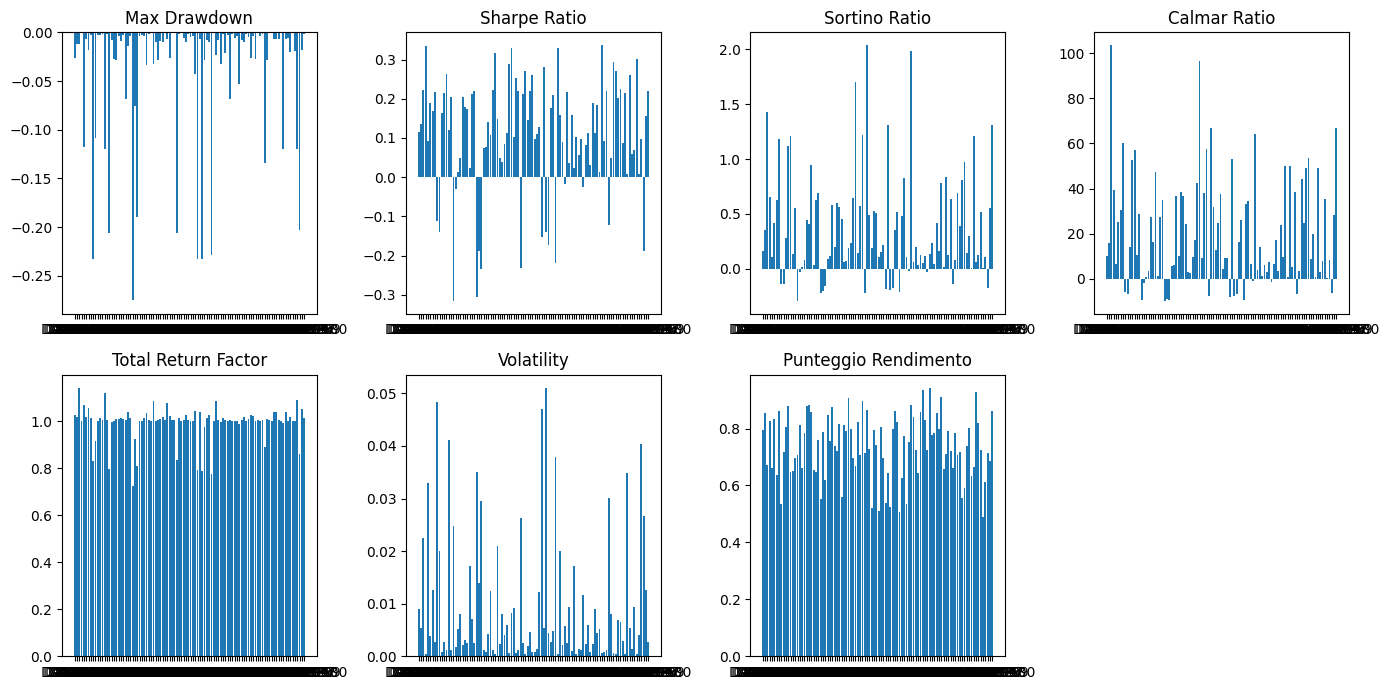

In [171]:
# Plot dei risultati
plt.figure(figsize=(14, 7))

# Plot del Max Drawdown per ogni dataset
plt.subplot(2, 4, 1)
plt.bar(results_df['Dataset'], results_df['Max Drawdown'])
plt.title('Max Drawdown')

# Plot dello Sharpe Ratio per ogni dataset
plt.subplot(2, 4, 2)
plt.bar(results_df['Dataset'], results_df['Sharpe Ratio'])
plt.title('Sharpe Ratio')

# Plot del Sortino Ratio per ogni dataset
plt.subplot(2, 4, 3)
plt.bar(results_df['Dataset'], results_df['Sortino Ratio'])
plt.title('Sortino Ratio')

# Plot del Calmar Ratio per ogni dataset
plt.subplot(2, 4, 4)
plt.bar(results_df['Dataset'], results_df['Calmar Ratio'])
plt.title('Calmar Ratio')

# Plot del Total Return Factor per ogni dataset
plt.subplot(2, 4, 5)
plt.bar(results_df['Dataset'], results_df['Total Return Factor'])
plt.title('Total Return Factor')

# Plot della Volatility per ogni dataset
plt.subplot(2, 4, 6)
plt.bar(results_df['Dataset'], results_df['Volatility'])
plt.title('Volatility')

# Plot del Punteggio Rendimento per ogni dataset
plt.subplot(2, 4, 7)
plt.bar(results_df['Dataset'], results_df['Punteggio Rendimento'])
plt.title('Punteggio Rendimento')

plt.tight_layout()
plt.show()

## Grid search

In [172]:
# # Esegui la grid search
# for ind, params in enumerate(param_combinations):
#     perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure = params
#     print(f'Sto calcolando la combinazione {ind+1}/{total_combinations} ({params})...')
    
#     for i, df in enumerate(dati_da_usare):
#         transactions = strategia_media_pesata_forzata_statica(df, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure)
#         portfolio_values = transactions['Valore Totale del Portafoglio']
        
#         # Calcola il Return Factor
#         total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
        
#         # Calcola il punteggio rendimento
#         punteggio_rendimento = total_return_factor / ideal_returns[i]
        
#         # Aggiorna la coppia migliore e peggiore
#         if punteggio_rendimento > best_pair['score']:
#             best_pair = {'score': punteggio_rendimento, 'dataset': i, 'params': params, 'transactions': transactions}
#         if punteggio_rendimento < worst_pair['score']:
#             worst_pair = {'score': punteggio_rendimento, 'dataset': i, 'params': params, 'transactions': transactions}
        
#         # Salva i risultati
#         grid_search_results.append({
#             'dataset': i,
#             'perc_primo_acquisto': perc_primo_acquisto,
#             'vendita_immediata': vendita_immediata,
#             'perc_sbilanciamento_acquisto': perc_sbilanciamento_acquisto,
#             'soglia_minima_acquisto': soglia_minima_acquisto,
#             'soglia_minima_vendita': soglia_minima_vendita,
#             'perc_stop_loss': perc_stop_loss,
#             'compra_pure': compra_pure,
#             'Fattore Rendimento': total_return_factor,
#             'Punteggio Rendimento': punteggio_rendimento
#         })

#     print(f'Completata combinazione {ind+1}/{total_combinations}')

# # Converte i risultati in DataFrame per una migliore visualizzazione
# grid_search_results_df = pd.DataFrame(grid_search_results)

# # Funzione per creare il grafico delle transazioni
# def plot_transactions(df, transactions, title):
#     plt.figure(figsize=(20, 7))
#     plt.grid(True)
#     plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
#     acquisti = transactions[transactions['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
#     vendite = transactions[transactions['Azione Attuale'] == 'Vendita']
    
#     plt.scatter(acquisti['Data'], acquisti['Prezzo'], 
#                 s=acquisti['Quantità in € Comprata/Venduta']/acquisti['Quantità in € Comprata/Venduta'].max()*200, 
#                 color='green', alpha=0.6, label='Acquisti')
#     plt.scatter(vendite['Data'], vendite['Prezzo'], 
#                 s=vendite['Quantità in € Comprata/Venduta']/vendite['Quantità in € Comprata/Venduta'].max()*200, 
#                 color='red', alpha=0.6, label='Vendite')
    
#     plt.title(title)
#     plt.xlabel('Data')
#     plt.ylabel('Prezzo')
#     plt.legend()
#     plt.show()

# # Stampa e visualizza i risultati per la coppia migliore
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Punteggio: {best_pair['score']}")
# plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la Miglior Coppia')
# print("\nElenco transazioni per la miglior coppia:")
# print(best_pair['transactions'])

# # Stampa e visualizza i risultati per la coppia peggiore
# print("\nPeggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Punteggio: {worst_pair['score']}")
# plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la Peggior Coppia')
# print("\nElenco transazioni per la peggior coppia:")
# print(worst_pair['transactions'])

### Grid search su media pesata forzata (con variabili dinamiche)

In [177]:
# Parametri da variare nella grid search
perc_primo_acquisto_values = [0.001, 0.01, 0.1]
vendita_immediata_values = [True, False]
perc_sbilanciamento_acquisto_values = [0.5, 0.55, 0.6]
soglia_minima_acquisto_values = [0, 0.01, 0.3]
soglia_minima_vendita_values = [0, 0.01, 0.3]
perc_stop_loss_values = [0, 0.01, 0.1]
compra_pure_values = [True, False]
vendita_immediata_dinamica_values = [True, False] # Valutare se usare il numero medio di salite consecutive anzichè l'rsi
tempo_rsi_values = [3, 7, 10]
soglia_rsi_values = [25, 50, 75] # Percentuale già moltiplicata per 100, quindi è un numero da 0 a 100!
metodo_values = ['rsi', 'salite_discese_consecutive']
tempo_salite_discese_consecutive_values = [7, 14, 21]
soglia_salite_consecutive_values = [1, 2, 3] # Numeri reali >= 1
coefficienti_acquisto_values =  [list(combinazione) for combinazione in list(itertools.product([0, 0.5, 1], [0.5, 0.90625, 1.3], [-1, -1.41667, -2], [0, 0.617188, 1], [-1, -0.114583, 1], [0.003, 0.0078125, 0.013]))] # Ogni valore di ogni lista è in generale un numero reale (a parte la prima lista che è direttamente il valore che assume perc_acquisto se la lunghezza media delle discese è 0); qui sto creando una lista con tutte le possibili combinazioni dei valori di ogni lista, quindi mi darà un elenco di liste dove ogni lista contiene un elenco di coefficienti acquisto (ad esempio [1, 0.90625, -1.41667, 0.617188, -0.114583, 0.0078125]; questa combinazione in particolare rappresenta la lista dei coefficienti del polinomio di grado 5 che mappa 0 in 1, 1 in 1, 2 in 0.5, 3 in 0.25, 4 in 0.125, 5 in 0.0625)

# Parametri fissi
liquidita_mobile_iniziale = 1000
liquidita_fissa_iniziale = 0
bitcoin_iniziali = 0
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
min_acquisto = 5
min_vendita = 5

# Calcola il rendimento ideale per ogni dataset e salva in una lista
ideal_returns = [calcola_rendimento_portafoglio_ideale(liquidita_mobile_iniziale + liquidita_fissa_iniziale, bitcoin_iniziali, df['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)[0] for df in dati_da_usare]

# Inizializza variabili per tenere traccia delle coppie migliori e peggiori
best_pair = {'score': -np.inf, 'total_return_factor': -np.inf, 'dataset': None, 'params': None, 'transactions': None}
worst_pair = {'score': np.inf, 'total_return_factor': np.inf, 'dataset': None, 'params': None, 'transactions': None}

# Lista per conservare i risultati della grid search
grid_search_results = []

# Genera tutte le combinazioni possibili dei parametri
param_combinations = list(itertools.product(perc_primo_acquisto_values, vendita_immediata_values, 
                                       perc_sbilanciamento_acquisto_values, soglia_minima_acquisto_values, soglia_minima_vendita_values, 
                                       perc_stop_loss_values, compra_pure_values, vendita_immediata_dinamica_values, tempo_rsi_values, soglia_rsi_values, metodo_values, tempo_salite_discese_consecutive_values, soglia_salite_consecutive_values, coefficienti_acquisto_values))

# Numero totale di combinazioni
total_combinations = len(param_combinations)

max_value = 0
max_rendimento_medio = 0

ind_partenza = 1 # Punteggio rendimento medio migliore trovato finora: 0.5505895880403654 con i parametri ['perc_primo_acquisto=0.012', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.54', 'soglia_minima_acquisto=0.118', 'soglia_minima_vendita=0.3', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13'] e fattore rendimento medio 1.003625046999349 (combinazione numero 3) # Punteggio rendimento medio migliore trovato finora: 0.5776941064250096 con i parametri ['perc_primo_acquisto=0.01', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.5', 'soglia_minima_acquisto=0', 'soglia_minima_vendita=0', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=7', 'soglia_rsi=0.25'] e fattore rendimento medio 1.0455709136190958 (combinazione numero 1)


ind_fine = total_combinations

saltate = 0
calcolate = 0

# Esegui la grid search
for ind, params in enumerate(param_combinations):
    if ind + 1 >= ind_partenza and ind + 1 <= ind_fine:
        perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto = params

        nomi_parametri = ['perc_primo_acquisto', 'vendita_immediata', 'perc_sbilanciamento_acquisto', 'soglia_minima_acquisto', 'soglia_minima_vendita', 'perc_stop_loss', 'compra_pure', 'vendita_immediata_dinamica', 'tempo_rsi', 'soglia_rsi', 'metodo', 'tempo_salite_discese_consecutive', 'soglia_salite_consecutive', 'coefficienti_acquisto']
        parametri_e_valori = [nomi_parametri[j] + "=" + str(params[j]) for j in range(len(params))]

        if not vendita_immediata_dinamica and (tempo_rsi != tempo_rsi_values[0] or soglia_rsi != soglia_rsi_values[0] or metodo != metodo_values[0] or tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0]) or vendita_immediata_dinamica and vendita_immediata != vendita_immediata_values[0] or perc_primo_acquisto == 1 and (perc_sbilanciamento_acquisto != perc_sbilanciamento_acquisto_values[0] or soglia_minima_acquisto != soglia_minima_acquisto_values[0] or compra_pure != compra_pure_values[0]) or vendita_immediata and perc_stop_loss != perc_stop_loss_values[0] or metodo != 'salite_discese_consecutive' and (tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0]):
            print(f'Salto la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) perchè sarebbe identica a una combinazione già vista...\n')
            saltate += 1
            continue

        print(f'Sto calcolando la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) ({calcolate} calcolate, {saltate} saltate)...')
        calcolate += 1
        
        # Liste per conservare i rendimenti per ogni dataset
        total_return_factors = []
        
        for i, df in enumerate(dati_da_usare):
            transactions = strategia_media_pesata_forzata_dinamica(df, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto)
            
            portfolio_values = transactions['Valore Totale del Portafoglio']
            
            # Calcola i rendimenti giornalieri del portafoglio
            # portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]

            # Calcolo il Return Factor
            total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
            total_return_factors.append(total_return_factor)

            # Calcola il punteggio rendimento
            punteggio_rendimento = total_return_factor / ideal_returns[i]
            
            # Aggiorna la coppia migliore e peggiore
            if punteggio_rendimento > best_pair['score']:
                best_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}
            if punteggio_rendimento < worst_pair['score']:
                worst_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}

        rendimento_medio = np.mean(total_return_factors)
        
        # Calcola il punteggio rendimento medio per la combinazione di parametri
        punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
        
        # Salva i risultati
        grid_search_results.append({
            'perc_primo_acquisto': perc_primo_acquisto,
            'vendita_immediata': vendita_immediata,
            'perc_sbilanciamento_acquisto': perc_sbilanciamento_acquisto,
            'soglia_minima_acquisto': soglia_minima_acquisto,
            'soglia_minima_vendita': soglia_minima_vendita,
            'perc_stop_loss': perc_stop_loss,
            'compra_pure': compra_pure,
            'vendita_immediata_dinamica': vendita_immediata_dinamica,
            'tempo_rsi': tempo_rsi,
            'soglia_rsi': soglia_rsi,
            'metodo': metodo,
            'tempo_salite_discese_consecutive': tempo_salite_discese_consecutive,
            'soglia_salite_consecutive': soglia_salite_consecutive,
            'coefficienti_acquisto': coefficienti_acquisto,
            'Fattore Rendimento Medio': rendimento_medio,
            'Punteggio Rendimento Medio': punteggio_rendimento_medio
        })

        print(f'Fattore Rendimento Medio: {rendimento_medio}')
        print(f'Punteggio rendimento medio: {punteggio_rendimento_medio}')

        if punteggio_rendimento_medio > max_value:
            max_value = punteggio_rendimento_medio
            max_rendimento_medio = rendimento_medio
            combinazione_max = parametri_e_valori
            ind_max = ind

        print(f'Punteggio rendimento medio migliore trovato finora: {max_value} con i parametri {combinazione_max} e fattore rendimento medio {max_rendimento_medio} (combinazione numero {ind_max+1})\n')

# Converte i risultati in DataFrame per una migliore visualizzazione
grid_search_results_df = pd.DataFrame(grid_search_results)

# Ordina i risultati per Punteggio Rendimento Medio in ordine decrescente
sorted_results_df = grid_search_results_df.sort_values(by='Punteggio Rendimento Medio', ascending=False)

In [176]:
sorted_results_df.head(15)

NameError: name 'sorted_results_df' is not defined

In [ ]:
sorted_results_df[['Fattore Rendimento Medio', 'Punteggio Rendimento Medio']].value_counts()

Fattore Rendimento medio  Punteggio Rendimento Medio
1.003451                  0.550486                      1
1.003465                  0.550550                      1
1.003515                  0.550568                      1
1.003625                  0.550590                      1
Name: count, dtype: int64

In [244]:
def plot_transactions(df, transactions, title):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    transactions['Data'] = pd.to_datetime(transactions['Data'])
    
    plt.figure(figsize=(20, 7))
    plt.grid()
    plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
    acquisti = transactions[transactions['Azione Attuale'].isin(['Acquisto', 'Primo Acquisto'])]
    vendite = transactions[transactions['Azione Attuale'].isin(['Vendita', 'Vendita (Stop-Loss)'])]
    
    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['Quantità in € Comprata/Venduta'].max()
    max_vendita = vendite['Quantità in € Comprata/Venduta'].max()
    
    def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
        return min_size + (max_size - min_size) * (quantita / max_quantita)
    
    # Rimuovi eventuali NaN o infiniti
    # acquisti = acquisti.dropna(subset=['Data', 'Prezzo', 'Quantità in € Comprata/Venduta'])
    # vendite = vendite.dropna(subset=['Data', 'Prezzo', 'Quantità in € Comprata/Venduta'])
    
    dimensioni_acquisti = acquisti['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_acquisto))
    dimensioni_vendite = vendite['Quantità in € Comprata/Venduta'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
    # Verifica che tutte le dimensioni siano corrette
    assert len(acquisti['Data']) == len(acquisti['Prezzo']) == len(dimensioni_acquisti)
    assert len(vendite['Data']) == len(vendite['Prezzo']) == len(dimensioni_vendite)
    
    if not acquisti.empty:
        plt.scatter(acquisti['Data'], acquisti['Prezzo'], 
                    s=dimensioni_acquisti, 
                    color='green', alpha=0.6, label='Acquisti')
    
    if not vendite.empty:
        plt.scatter(vendite['Data'], vendite['Prezzo'], 
                    s=dimensioni_vendite, 
                    color='red', alpha=0.6, label='Vendite')
    
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.show()


Miglior coppia:
Dataset: 3
Parametri: ['perc_primo_acquisto=0.012', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.54', 'soglia_minima_acquisto=0.118', 'soglia_minima_vendita=0.3', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']
Fattore di rendimento totale: 1.3355427360979517
Punteggio: 0.7371451784369935


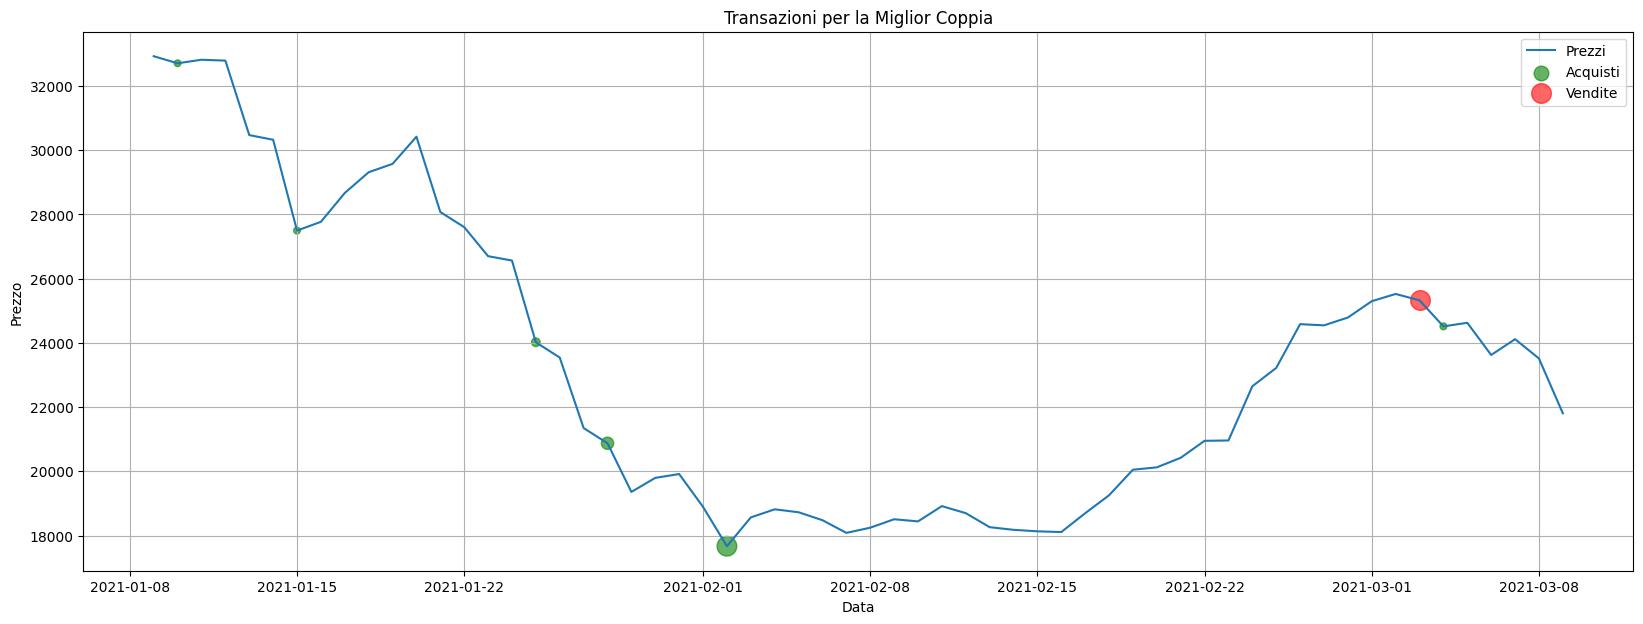


Elenco transazioni per la miglior coppia:


,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
0,2021-01-10,1,32708.328378,-,Primo Acquisto,0.012000,12.000000,0.000367,988.000000,0,0.000367,999.988000
5,2021-01-15,6,27498.070598,Primo Acquisto,Acquisto,0.014258,14.086957,0.000512,973.913043,0,0.000878,998.064290
15,2021-01-25,16,24019.139213,Acquisto,Acquisto,0.071560,69.693220,0.002899,904.219823,0,0.003777,994.939091
18,2021-01-28,19,20874.695090,Acquisto,Acquisto,0.241541,218.406301,0.010452,685.813522,0,0.014229,982.844253
23,2021-02-02,24,17668.103954,Acquisto,Acquisto,0.987039,676.924828,0.038275,8.888694,0,0.052504,936.540021
52,2021-03-03,53,25326.577660,Acquisto,Vendita (Stop-Loss),1.000000,1328.424330,0.052504,1337.313024,0,0.000000,1337.313024
53,2021-03-04,54,24514.875006,Vendita (Stop-Loss),Primo Acquisto,0.012000,16.047756,0.000654,1321.265267,0,0.000654,1337.296976


In [245]:
# Stampa e visualizza i risultati per la coppia migliore
print("\nMiglior coppia:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Parametri: {best_pair['params']}")
print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
print(f"Punteggio: {best_pair['score']}")
plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la Miglior Coppia')
print("\nElenco transazioni per la miglior coppia:")
best_pair['transactions'][best_pair['transactions']['Azione Attuale'] != '-']


Peggior coppia:
Dataset: 70
Parametri: ['perc_primo_acquisto=0.011', 'vendita_immediata=True', 'perc_sbilanciamento_acquisto=0.54', 'soglia_minima_acquisto=0.118', 'soglia_minima_vendita=0.3', 'perc_stop_loss=0', 'compra_pure=True', 'vendita_immediata_dinamica=True', 'tempo_rsi=3', 'soglia_rsi=13']
Fattore di rendimento totale: 1.0052122650368658
Punteggio: 0.4154832436463332


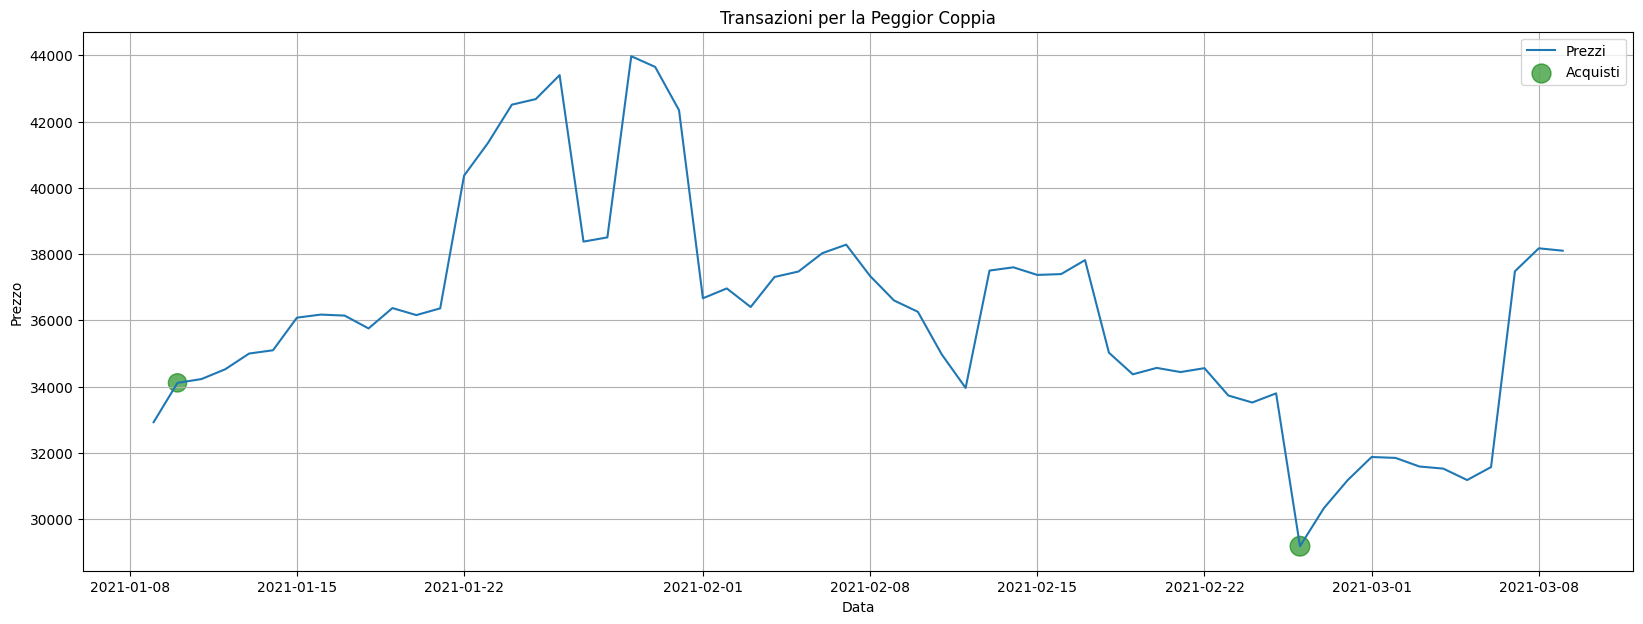


Elenco transazioni per la peggior coppia:


,Data,Numero giorno,Prezzo,Ultima Azione,Azione Attuale,% acquisto/vendita di LM,Quantità in € Comprata/Venduta,Quantità di Bitcoin Comprati/Venduti,Liquidità Mobile,Liquidità Fissa,Bitcoin Posseduti,Valore Totale del Portafoglio
0,2021-01-10,1,34114.977003,-,Primo Acquisto,0.011000,11.000000,0.000322,989.000000,0,0.000322,999.989000
47,2021-02-26,48,29186.384923,Primo Acquisto,Acquisto,0.013057,12.913043,0.000442,976.086957,0,0.000764,998.388506


In [246]:
# Stampa e visualizza i risultati per la coppia peggiore
print("\nPeggior coppia:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Parametri: {worst_pair['params']}")
print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
print(f"Punteggio: {worst_pair['score']}")
plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la Peggior Coppia')
print("\nElenco transazioni per la peggior coppia:")
worst_pair['transactions'][worst_pair['transactions']['Azione Attuale'] != '-']

### Grid search su media pesata forzata bidirezionale

In [461]:
# Parametri da variare nella grid search
percentuale_sbilanciamento_acquisti_values = [0.53, 0.55, 0.6]
percentuale_sbilanciamento_vendite_values = [0.35, 0.38, 0.39]
percentuale_primo_acquisto_values = [0.005, 0.006, 0.007]
percentuale_prima_vendita_values = [0.43, 0.45, 0.48]
vendi_pure_values = [True, False]
compra_pure_values = [True, False]
soglia_minima_vendita_values = [0.001, 0.0013, 0.0014]

liquidità_iniziale = 1000
bitcoin_iniziali = 0
percentuale_commissione_acquisti = 0.001
percentuale_commissione_vendite = 0.001
acquisto_minimo = 5
vendita_minima = 5


# Calcola il rendimento ideale per ogni dataset e salva in una lista
ideal_returns = [calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, df['Price'], min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)[0] for df in dati_da_usare]

# Inizializza variabili per tenere traccia delle coppie migliori e peggiori
best_pair = {'score': -np.inf, 'total_return_factor': -np.inf, 'dataset': None, 'params': None, 'transactions': None}
worst_pair = {'score': np.inf, 'total_return_factor': np.inf, 'dataset': None, 'params': None, 'transactions': None}

# Lista per conservare i risultati della grid search
grid_search_results = []

# Genera tutte le combinazioni possibili dei parametri
param_combinations = list(itertools.product(percentuale_sbilanciamento_acquisti_values, percentuale_sbilanciamento_vendite_values, 
                                       percentuale_primo_acquisto_values, percentuale_prima_vendita_values, vendi_pure_values, 
                                       compra_pure_values, soglia_minima_vendita_values))

# Numero totale di combinazioni
total_combinations = len(param_combinations)

max_value = 0
max_rendimento_medio = 0

ind_partenza = 1

ind_fine = total_combinations


saltate = 0
calcolate = 0

# Esegui la grid search
for ind, params in enumerate(param_combinations):
    if ind + 1 >= ind_partenza and ind + 1 <= ind_fine:
        percentuale_sbilanciamento_acquisti, percentuale_sbilanciamento_vendite, percentuale_primo_acquisto, percentuale_prima_vendita, vendi_pure, compra_pure, soglia_minima_vendita = params

        nomi_parametri = ['percentuale_sbilanciamento_acquisti', 'percentuale_sbilanciamento_vendite', 'percentuale_primo_acquisto', 'percentuale_prima_vendita', 'vendi_pure', 'compra_pure', 'soglia_minima_vendita']
        parametri_e_valori = [nomi_parametri[j] + "=" + str(params[j]) for j in range(len(params))]

        if not True:
            print(f'Salto la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) perchè sarebbe identica a una combinazione già vista...\n')
            saltate += 1
            continue

        print(f'Sto calcolando la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) ({calcolate} calcolate, {saltate} saltate)...')
        calcolate += 1
        
        # Liste per conservare i rendimenti per ogni dataset
        total_return_factors = []

        
        for i, df in enumerate(dati_da_usare):
            transactions = strategia_media_pesata_forzata_bidirezionale(df, liquidità_iniziale, bitcoin_iniziali, percentuale_sbilanciamento_acquisti, percentuale_sbilanciamento_vendite, percentuale_primo_acquisto, percentuale_prima_vendita, percentuale_commissione_acquisti, percentuale_commissione_vendite, acquisto_minimo, vendita_minima, vendi_pure, compra_pure, soglia_minima_vendita)
            
            portfolio_values = transactions['valore_totale_portafoglio']
            
            # Calcola i rendimenti giornalieri del portafoglio
            # portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]

            # Calcolo il Return Factor
            total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
            total_return_factors.append(total_return_factor)

            # Calcola il punteggio rendimento
            punteggio_rendimento = total_return_factor / ideal_returns[i]
            
            # Aggiorna la coppia migliore e peggiore
            if punteggio_rendimento > best_pair['score']:
                best_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}
            if punteggio_rendimento < worst_pair['score']:
                worst_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}

        rendimento_medio = np.mean(total_return_factors)
        
        # Calcola il punteggio rendimento medio per la combinazione di parametri
        punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
        
        # Salva i risultati
        grid_search_results.append({
            'percentuale_sbilanciamento_acquisti': percentuale_sbilanciamento_acquisti,
            'percentuale_sbilanciamento_vendite': percentuale_sbilanciamento_vendite,
            'percentuale_primo_acquisto': percentuale_primo_acquisto,
            'percentuale_prima_vendita': percentuale_prima_vendita,
            'vendi_pure': vendi_pure,
            'compra_pure': compra_pure,
            'soglia_minima_vendita': soglia_minima_vendita,
            'Fattore Rendimento Medio': rendimento_medio,
            'Punteggio Rendimento Medio': punteggio_rendimento_medio
        })

        print(f'Fattore Rendimento Medio: {rendimento_medio}')
        print(f'Punteggio rendimento medio: {punteggio_rendimento_medio}')

        if punteggio_rendimento_medio > max_value:
            max_value = punteggio_rendimento_medio
            max_rendimento_medio = rendimento_medio
            combinazione_max = parametri_e_valori
            ind_max = ind

        print(f'Punteggio rendimento medio migliore trovato finora: {max_value} con i parametri {combinazione_max} e fattore rendimento medio {max_rendimento_medio} (combinazione numero {ind_max+1})\n')

# Converte i risultati in DataFrame per una migliore visualizzazione
grid_search_results_df = pd.DataFrame(grid_search_results)

# Ordina i risultati per Punteggio Rendimento Medio in ordine decrescente
sorted_results_df = grid_search_results_df.sort_values(by='Punteggio Rendimento Medio', ascending=False)

Sto calcolando la combinazione 1/972 (['percentuale_sbilanciamento_acquisti=0.53', 'percentuale_sbilanciamento_vendite=0.35', 'percentuale_primo_acquisto=0.005', 'percentuale_prima_vendita=0.43', 'vendi_pure=True', 'compra_pure=True', 'soglia_minima_vendita=0.001']) (0 calcolate, 0 saltate)...
Fattore Rendimento Medio: 1.0095444833917109
Punteggio rendimento medio: 0.5524317157055193
Punteggio rendimento medio migliore trovato finora: 0.5524317157055193 con i parametri ['percentuale_sbilanciamento_acquisti=0.53', 'percentuale_sbilanciamento_vendite=0.35', 'percentuale_primo_acquisto=0.005', 'percentuale_prima_vendita=0.43', 'vendi_pure=True', 'compra_pure=True', 'soglia_minima_vendita=0.001'] e fattore rendimento medio 1.0095444833917109 (combinazione numero 1)

Sto calcolando la combinazione 2/972 (['percentuale_sbilanciamento_acquisti=0.53', 'percentuale_sbilanciamento_vendite=0.35', 'percentuale_primo_acquisto=0.005', 'percentuale_prima_vendita=0.43', 'vendi_pure=True', 'compra_pure

In [462]:
sorted_results_df.head(15)

,percentuale_sbilanciamento_acquisti,percentuale_sbilanciamento_vendite,percentuale_primo_acquisto,percentuale_prima_vendita,vendi_pure,compra_pure,soglia_minima_vendita,Fattore Rendimento Medio,Punteggio Rendimento Medio
602,0.55,0.39,0.006,0.48,True,True,0.0014,1.011551,0.552828
601,0.55,0.39,0.006,0.48,True,True,0.0013,1.011458,0.552786
482,0.55,0.38,0.006,0.45,True,True,0.0014,1.011493,0.552764
590,0.55,0.39,0.006,0.45,True,True,0.0014,1.011405,0.552738
481,0.55,0.38,0.006,0.45,True,True,0.0013,1.011386,0.552715
600,0.55,0.39,0.006,0.48,True,True,0.0010,1.011314,0.552701
589,0.55,0.39,0.006,0.45,True,True,0.0013,1.011301,0.552691
480,0.55,0.38,0.006,0.45,True,True,0.0010,1.011237,0.552627
588,0.55,0.39,0.006,0.45,True,True,0.0010,1.011155,0.552604
386,0.55,0.35,0.006,0.48,True,True,0.0014,1.011113,0.552599


In [463]:
sorted_results_df[['Fattore Rendimento Medio', 'Punteggio Rendimento Medio']].value_counts()

Fattore Rendimento Medio  Punteggio Rendimento Medio
1.004783                  0.549374                      3
1.008449                  0.551921                      3
1.008530                  0.551917                      3
1.002756                  0.548204                      3
1.001653                  0.548411                      3
                                                       ..
1.000833                  0.547317                      1
1.000840                  0.548112                      1
1.000841                  0.548119                      1
1.000844                  0.548094                      1
1.011551                  0.552828                      1
Name: count, Length: 867, dtype: int64

In [464]:
transactions.columns

Index(['data', 'prezzo', 'azione', 'ultima azione',
       'percentuale_liquidità_usata', 'percentuale_token_venduti',
       'quantità_euro', 'quantità_bitcoin', 'liquidità_posseduta',
       'bitcoin_posseduti', 'valore_totale_portafoglio'],
      dtype='object')

In [465]:
def plot_transactions(df, transactions, title):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    transactions['data'] = pd.to_datetime(transactions['data'])
    
    plt.figure(figsize=(20, 7))
    plt.grid()
    plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
    acquisti = transactions[transactions['azione'].isin(['acquisto'])]
    vendite = transactions[transactions['azione'].isin(['vendita'])]
    
    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['quantità_euro'].max()
    max_vendita = vendite['quantità_euro'].max()
    
    def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
        return min_size + (max_size - min_size) * (quantita / max_quantita)
    
    # Rimuovi eventuali NaN o infiniti
    # acquisti = acquisti.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    # vendite = vendite.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    
    dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
    dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
    # Verifica che tutte le dimensioni siano corrette
    assert len(acquisti['data']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
    assert len(vendite['data']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
    if not acquisti.empty:
        plt.scatter(acquisti['data'], acquisti['prezzo'], 
                    s=dimensioni_acquisti, 
                    color='green', alpha=0.6, label='Acquisti')
    
    if not vendite.empty:
        plt.scatter(vendite['data'], vendite['prezzo'], 
                    s=dimensioni_vendite, 
                    color='red', alpha=0.6, label='Vendite')
    
    plt.title(title)
    plt.xlabel('data')
    plt.ylabel('prezzo')
    plt.legend()
    plt.show()


Miglior coppia:
Dataset: 27
Parametri: ['percentuale_sbilanciamento_acquisti=0.55', 'percentuale_sbilanciamento_vendite=0.35', 'percentuale_primo_acquisto=0.007', 'percentuale_prima_vendita=0.43', 'vendi_pure=True', 'compra_pure=True', 'soglia_minima_vendita=0.001']
Fattore di rendimento totale: 1.0519992416725232
Punteggio: 0.7530568626433412


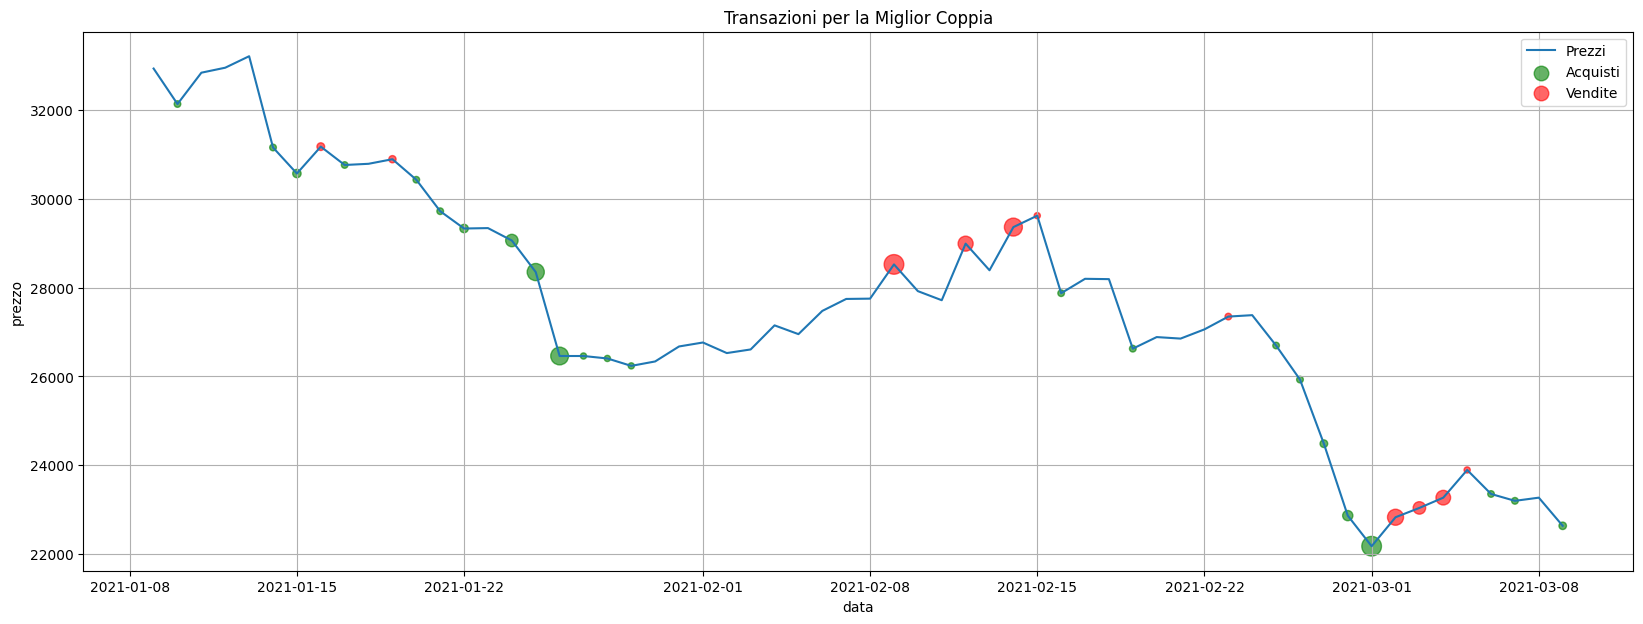


Elenco transazioni per la miglior coppia:


,data,prezzo,azione,ultima azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-01-10,32129.415549,acquisto,acquisto,"(0.7000000000000001, 2)",0,7.000000,0.000218,993.000000,0.000218,999.993000
4,2021-01-14,31151.779407,acquisto,acquisto,"(0.8615866621908873, 2)",0,8.555556,0.000274,984.444444,0.000492,999.771661
5,2021-01-15,30565.986522,acquisto,acquisto,"(4.568381935326783, 2)",0,44.973182,0.001470,939.471262,0.001962,999.438467
6,2021-01-16,31170.995118,vendita,vendita,0,"(43.0, 2)",26.296292,0.000844,965.767554,0.001118,1000.625430
7,2021-01-17,30758.073862,acquisto,acquisto,"(0.7000000000000001, 2)",0,6.760373,0.000220,959.007181,0.001338,1000.156908
9,2021-01-19,30888.205839,vendita,vendita,0,"(43.0, 2)",17.769244,0.000575,976.776426,0.000763,1000.331005
10,2021-01-20,30426.292673,acquisto,acquisto,"(0.7000000000000001, 2)",0,6.837435,0.000224,969.938991,0.000987,999.971924
11,2021-01-21,29718.300347,acquisto,acquisto,"(0.861586662190892, 2)",0,8.356865,0.000281,961.582126,0.001268,999.264728
12,2021-01-22,29328.751375,acquisto,acquisto,"(4.803120361108168, 2)",0,46.185947,0.001573,915.396179,0.002841,998.724597
14,2021-01-24,29058.735914,acquisto,acquisto,"(17.869099397466226, 2)",0,163.573053,0.005623,751.823126,0.008465,997.793860


In [466]:
# Stampa e visualizza i risultati per la coppia migliore
print("\nMiglior coppia:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Parametri: {best_pair['params']}")
print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
print(f"Punteggio: {best_pair['score']}")
plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la Miglior Coppia')
print("\nElenco transazioni per la miglior coppia:")
best_pair['transactions'][best_pair['transactions']['azione'] != '-']


Peggior coppia:
Dataset: 46
Parametri: ['percentuale_sbilanciamento_acquisti=0.6', 'percentuale_sbilanciamento_vendite=0.35', 'percentuale_primo_acquisto=0.007', 'percentuale_prima_vendita=0.48', 'vendi_pure=True', 'compra_pure=True', 'soglia_minima_vendita=0.001']
Fattore di rendimento totale: 0.8777285435659851
Punteggio: 0.3931967346881151


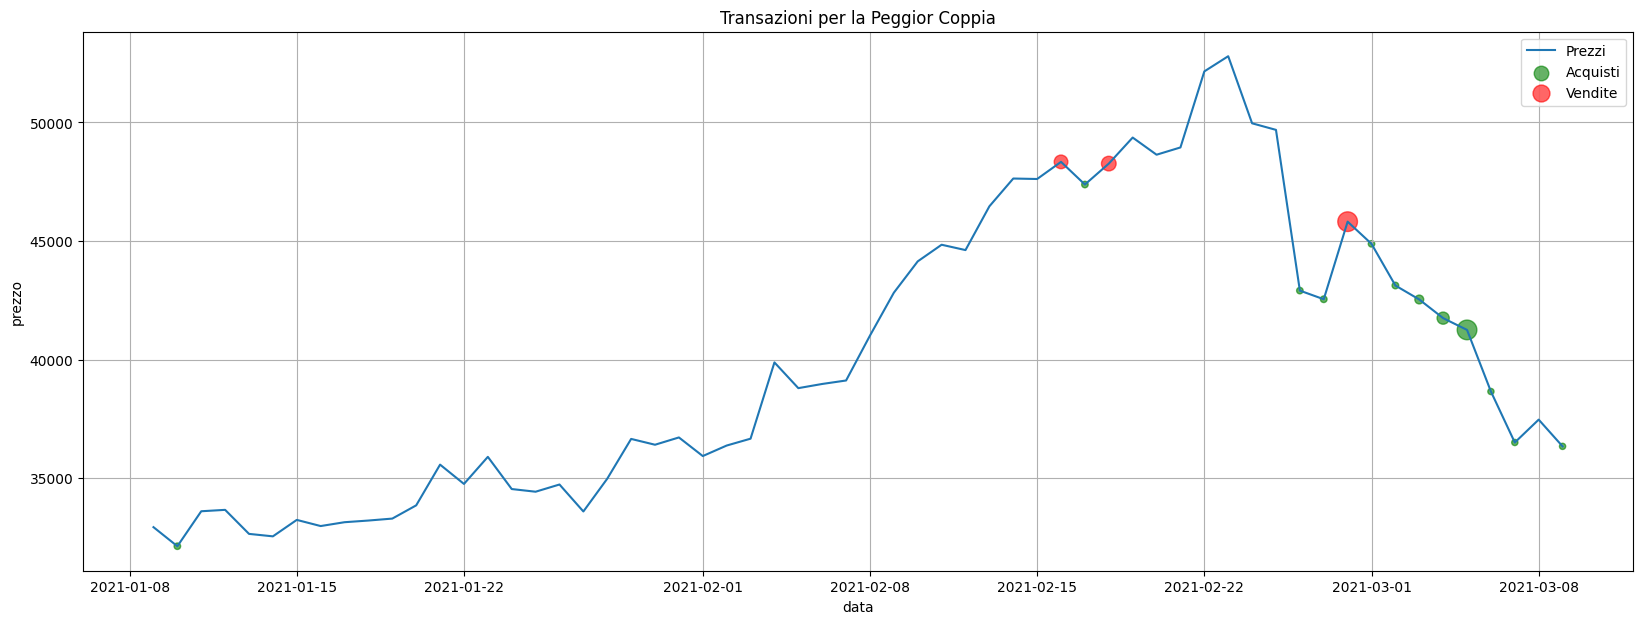


Elenco transazioni per la peggior coppia:


,data,prezzo,azione,ultima azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-01-10,32123.863256,acquisto,acquisto,"(0.7000000000000001, 2)",0,7.000000,0.000218,993.000000,0.000218,999.993000
37,2021-02-16,48337.019769,vendita,vendita,0,"(48.0, 2)",5.050762,0.000104,998.050762,0.000113,1003.522420
38,2021-02-17,47381.195169,acquisto,acquisto,"(0.7000000000000001, 2)",0,6.986355,0.000147,991.064406,0.000261,1003.407236
39,2021-02-18,48264.360033,vendita,vendita,0,"(48.0, 2)",6.034990,0.000125,997.099396,0.000135,1003.637301
47,2021-02-26,42906.492725,acquisto,acquisto,"(0.7000000000000001, 2)",0,6.979696,0.000163,990.119700,0.000298,1002.904543
48,2021-02-27,42542.341642,acquisto,acquisto,"(1.0574018126888205, 2)",0,10.469544,0.000246,979.650156,0.000544,1002.785567
49,2021-02-28,45814.804922,vendita,vendita,0,"(47.99999999999999, 2)",11.959221,0.000261,991.609378,0.000283,1004.565201
50,2021-03-01,44879.413433,acquisto,acquisto,"(0.7000000000000001, 2)",0,6.941266,0.000155,984.668112,0.000437,1004.293743
51,2021-03-02,43121.324574,acquisto,acquisto,"(1.057401812688824, 2)",0,10.411898,0.000241,974.256214,0.000679,1003.514525
52,2021-03-03,42531.171399,acquisto,acquisto,"(7.977930662075526, 2)",0,77.725485,0.001826,896.530728,0.002504,1003.036373


In [467]:
# Stampa e visualizza i risultati per la coppia peggiore
print("\nPeggior coppia:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Parametri: {worst_pair['params']}")
print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
print(f"Punteggio: {worst_pair['score']}")
plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la Peggior Coppia')
print("\nElenco transazioni per la peggior coppia:")
worst_pair['transactions'][worst_pair['transactions']['azione'] != '-']

## Idee

In [468]:
# Idee successive:
# - Capire perchè con alcuni dataset una certa combinazione funziona bene e un'altra funziona male
# - Per farlo, clusterizzare i dataset (numero di cluster da decidere) per ogni combinazione (ad esempio, per una fissata combinazione, un gruppo di dataset può aver performato benissimo, un altro così così e un altro malissimo)
# - Cercare di capire cos'hanno in comune i dataset di uno stesso cluster e cercare di definire poi una o più caratteristiche che permettono di distinguere tali cluster
# - Sulla base delle caratteristiche definite, modificare la strategia di trading in modo da cambiare dinamicamente le variabili, così da avere sempre, idealmente, la combinazione migliore per il tipo di dataset riconosciuto

In [469]:
# Usare come dataset i prezzi di periodi casuali di dimensione variabile e come target il rendimento medio giornaliero per normalizzare

In [470]:
# Altra idea:
# - Generare tantissimi dataset diversi
# - Trovare in qualche modo (ad esempio una grid search), per ogni dataset, i parametri migliori della mia strategia che si avvicinano il più possibile a un punteggio rendimento del 100%
# - Per ognuno di quei dataset, creare delle colonne per rappresentare varie features utili (medie mobili, deviazioni standard mobili, valori mobili delle bollinger bands, numero medio di salite e discese consecutive, rapporto tra ultimo e primo prezzo, ..., e magari anche derivate di tutte queste grandezze e/o combinazioni di queste grandezze), in modo che insieme rappresentino il più possibile quel dataset univoco (valutare se come features si possono usare i prezzi stessi del dataset, dato che, se si riesce a tenere conto del fatto che sono valori ordinati, rappresentano esattamente quel dataset univoco)
# - Fare machine learning per capire la relazione tra le caratteristiche di un certo dataset e i parametri migliori da usare per quel dataset
# - A partire da un nuovo dataset, a questo punto, basterà delineare le sue caratteristiche man mano che i giorni passano, e usare il modello costruito col machine learning per dire quali sono i migliori parametri della mia strategia da usare

In [471]:
# Generalizzare la strategia di trading in questi modi:
# - Permettere una vendita iniziale e varie vendite successive in modo analogo a quello che faccio con gli acquisti (il caso attuale corrisponderebbe a una vendita iniziale del 100%)
# - Permettere un acquisto solo se il prezzo è calato almeno di una certa percentuale rispetto al prezzo dell'ultimo acquisto (sempre all'interno di una serie di acquisti consecutivi intendo, quindi senza che sia avvenuta una vendita dopo quell'ultimo acquisto)

In [472]:
# Altra idea ancora:
# - Man mano che il tempo avanza, cercare ogni giorno (oppure ogni tot giorni) la combinazione di parametri migliore che avrei dovuto usare dall'inizio fino a quel giorno per ottenere un punteggio rendimento il più vicino possibile al 100%. Mi aspetto che la combinazione migliore cambi in modo continuo, cioè che non faccia cambiamenti bruschi (anche se questa cosa è da verificare)
# - Una volta ottenuta la combinazione migliore, cambiare i valori con quella combinazione. La strategia di trading stessa quindi diventa questa, con un aggiornamento continuo dei parametri, e quindi con parametri dinamici e non più statici
# Serve quindi un'altra function, cioè un altro algoritmo, che a partire da una sequenza di prezzi mi dice qual è la combinazione migliore (per alleggerire il peso computazionale, posso pensare anche di non usare tutta la sequenza di prezzi dal primo giorno, ma ad esempio solo gli ultimi 7 giorni)
# - Questa function è quella che avevo già cominciato a creare nella prima azienda e che avevo chiamato "grid search automatizzata"

In [473]:
# Altre idee:
# 1) Compravendita continua (perchè ogni giorno si acquista o si vende): https://chatgpt.com/share/d42a16ed-1edd-4092-b7ce-74a9fd2d901d
# 2) Aggiunta della vendta graduale: nuovo valore per vendita_immediata pari a "Graduale" che permette di vendere con la stessa logica dell'acquisto medio pesato e non sempre al 100%
# 3) Dividere la liquidità iniziale in N parti, e usare strategie tra loro diverse per ogni parte, in modo da tendere a guadagnarci con almeno 1 strategia